#                               CREDIT RATING PREDICTION TASK

This task is treated as a supervised classification task where both the labels and the features are provided. In this case,

#### Labels - Credit Ratings
#### Features - DATAITEMID and DATAITEMVALUE provided in the SPGlobalRatingsChallenge_Financials.txt files
The other attributes provided in the files were used for aggregating the data
This model gives an AUC (area under the curve) of 0.6571 on the best model

Initially some experiments were tried on extracting information from Balance Sheets, Cash Flow Statements and Income Statements. But, due to the elaborate web craping needed and given the time constraint, this component was skipped. Below, is the code used for the scraping using the Beautiful soup library in python
### 1) Web scraping code to extract the Balance Sheet, Cash Flow Statements and Income Statements

In [ ]:
from bs4 import BeautifulSoup
import os
import re
%matplotlib inline

In [ ]:
class DataScraping():
    
    def __init__(self, dir_10k):
        self.parent_dir = dir_10k
        self.table_name = None
        self.companies_folder = [d for d in os.listdir(dir_10k)]

        print self.companies_folder

    def get_values(self, company, f):
        values_dict = dict()
        
        if self.table_name == "CONSOLIDATED STATEMENTS OF CASH FLOWS":
            soup = BeautifulSoup(open(os.path.join(self.parent_dir, company, f), "r"))
        
        for elem in soup(text=re.compile(r'CONSOLIDATED STATEMENTS OF CASH FLOWS')):
            print elem.parent
            break
            
    def get_table(self, data_type):
        if data_type == "cash flow":
            self.table_name = "CONSOLIDATED STATEMENTS OF CASH FLOWS"
        elif data_type == "balance":
            self.table_name = "CONSOLIDATED BALANCE SHEETS"
        elif data_type == "income":
            self.table_name = "Consolidated Income Statements"
        
        self.data_dict = dict()
        
        for company in list(self.companies_folder):
            #sort the filenames by date
            files = sorted(os.listdir(os.path.join(self.parent_dir, company)))            
            print files
            self.data_dict[company] = dict()
            
            for f in files:
                self.data_dict[company][f] = self.get_values(company, f)
                
            print

    

In [ ]:
input_10k = "../10K"
data = DataScraping(input_10k)
data.get_table("cash flow")

A thorough EDA was performed on the data before proceeding to build the classifiers. Many useful insights were obtained
### Exploratory Data Analysis

In [247]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from matplotlib import pyplot
import math


### Reading in the required data

In [248]:
input_folder = "data/Financial&Rating/"
ratings_file = "SPGlobalRatingsChallenge_CompanyRatings.csv"
cross_ref_file = "SPGlobalRatingsChallenge_CompanyCrossReference.csv"
fin_file = "SPGlobalRatingsChallenge_Financials.txt"
descrip_file = "SPGlobalRatingsChallenge_FinancialItemsDescriptions.csv"
company_ratings = pd.read_csv(input_folder + ratings_file)
cross_ref = pd.read_csv(input_folder + cross_ref_file)
financial = pd.read_csv(input_folder + fin_file, sep = "|")
descrip = pd.read_csv(input_folder + descrip_file)

### Data Modifications
It is observed in the data files that each company has separate records for the separate dates/years on which the records were made. Therefore, it was necessary to seprate out the year from the rating date in the data table obtained from the SPGlobalRatingsChallenge_CompanyRatings.csv file. This would help with the table joins which are performed later in the pipeline

In [249]:
### Separate out the year from the date in company ratings table -- to facilitate in correct joining with the other tables
company_ratings["CALENDARYEAR"] = company_ratings["RATING_DATE"].apply(lambda x : int((x.split()[0]).split("/")[-1]))
company_ratings

,SP_ENTITY_ID,CURRENT_RATING_SYMBOL,RATING_DATE,CURRENT_CW_OL_DATE,CURRENT_CW_OL,CALENDARYEAR
0,100057,BBB-,02/02/2016 14:48:19,02/02/2016 14:48:19,Stable,2016
1,100057,BBB,07/22/2010 12:59:04,07/22/2010 12:59:04,Stable,2010
2,100057,BBB-,03/31/2004 13:07:28,03/31/2004 13:07:28,Negative,2004
3,100057,BBB-,03/31/2004 13:07:28,04/27/2005 12:02:38,Stable,2004
4,100057,BBB,08/03/2001 15:44:18,08/03/2001 15:44:18,Stable,2001
5,100057,BBB,08/03/2001 15:44:18,10/30/2002 12:04:43,Negative,2001
6,100057,BBB,08/03/2001 15:44:18,01/30/2003 16:51:35,Watch Neg,2001
7,100057,BBB,08/03/2001 15:44:18,06/16/2003 16:13:06,Negative,2001
8,100057,BBB+,11/07/2000 14:54:05,11/07/2000 14:54:05,Stable,2000
9,100057,BBB+,11/07/2000 14:54:05,07/10/2001 10:56:04,Watch Neg,2000


In [250]:
# descrip_dict = descrip.set_index('DATAITEMID').T.to_dict('list')


## Data Preprocessing

###  Add values for the missing data.
For some of the attributes, quite a few missing values were seen. Therefore, these were simply replaced with the "0" value. Since these attributes are not used in the classification later, other methods were not explored for imputing missing values

In [251]:

### Replacing the NA with 0

cross_ref.fillna("0", inplace=True)

financial.fillna("0", inplace=True)


#### Predcition Labels are given by the following column in the data: CURRENT_RATING_SYMBOL

In [252]:
### Label distribution in the entire dataset
labels_percent = 100 * company_ratings["CURRENT_RATING_SYMBOL"].value_counts() / len(company_ratings["CURRENT_RATING_SYMBOL"])
labels_percent


B       13.954238
B+      10.699323
BB-      8.636803
B-       8.346761
BBB-     8.153400
BB       7.863358
BB+      7.702224
BBB      6.961005
BBB+     6.735417
A-       4.318402
CCC+     3.351595
A        3.126007
A+       2.062520
CCC      1.353529
AA-      1.224621
SD       1.192394
NR       1.063487
CC       0.934579
CCC-     0.741218
AA       0.580084
D        0.483403
AA+      0.386723
AAA      0.128908
Name: CURRENT_RATING_SYMBOL, dtype: float64

#### Plot labels by their frequency

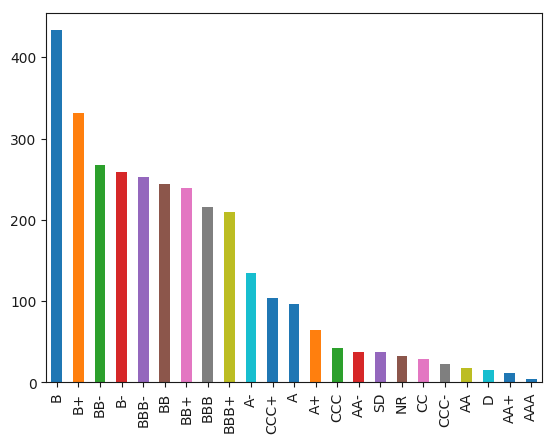

In [253]:
company_ratings["CURRENT_RATING_SYMBOL"].value_counts().plot("bar")

As it can be seen, the dataset is highly imbalanced. This does end up affecting the performance of the classifier later. Such data is challenging to work with and many times upsampling is used. But, in this work, application of upsampling did not improve the results and hence was not put as part of the implementation pipeline. This is also the reason why we should prefer looking at the AUC and ROC curves instead of just relying on the accuracy as a measure of prediction performance.

### Joining tables for better analysis 
The data from all the tables was consolidated into one single table in order to feed only one table as input into the classifier

In [254]:
### check if same set of SP_ENTITY_ID present in both the tables
comp_id = list(company_ratings["SP_ENTITY_ID"])
cross_id = list(cross_ref["SP_ENTITY_ID"])
c_id1 = cross_ref["COMPANYID"]
c_id2 = financial["COMPANYID"]
set(c_id1) == set(c_id2)
set(comp_id) == set(cross_id)

True

In [255]:
### Inner join on SP_ENTITY_ID as the same SP_ENTITY_IDs are present in two tables
join1 = pd.merge(company_ratings, cross_ref, on="SP_ENTITY_ID", how="inner")

### Outer join on ["COMPANYID", "CALENDARYEAR"], since these attributes are not exactly the same in the two tables
### And we don't want to miss any rows due to that
join2 = pd.merge(join1, financial, on=["COMPANYID", "CALENDARYEAR"], how="outer")

In [256]:
### subset of resulting table
join2.head()
# join2[['SP_ENTITY_ID', 'COMPANYID', 'EXCHANGESYMBOL', 'MARKET', 'COUNTRY', 'CCST_INDUSTRY', 'CIQ_INDUSTRY']]

,SP_ENTITY_ID,CURRENT_RATING_SYMBOL,RATING_DATE,CURRENT_CW_OL_DATE,CURRENT_CW_OL,CALENDARYEAR,COMPANYID,ISSUER_NAME,CCST_INDUSTRY,CIQ_NAME,...,TICKERSYMBOL,EXCHANGESYMBOL,COUNTRY,CURRENCYNAME,PERIODENDDATE,PERIODTYPENAME,CALENDARQUARTER,FILINGDATE,DATAITEMID,DATAITEMVALUE
0,100057.0,BBB-,02/02/2016 14:48:19,02/02/2016 14:48:19,Stable,2016,249841,Hess Corp,"Oil & Gas Integrated, Exploration & Production",Hess Corporation,...,0J50,LSE,United States,Reported Currency,12/31/2016,Annual,4.0,2/21/2018 12:00:00.000000 AM,4042.0,70.161102
1,100057.0,BBB-,02/02/2016 14:48:19,02/02/2016 14:48:19,Stable,2016,249841,Hess Corp,"Oil & Gas Integrated, Exploration & Production",Hess Corporation,...,0J50,LSE,United States,Reported Currency,12/31/2016,Annual,4.0,2/21/2018 12:00:00.000000 AM,4190.0,2.671597
2,100057.0,BBB-,02/02/2016 14:48:19,02/02/2016 14:48:19,Stable,2016,249841,Hess Corp,"Oil & Gas Integrated, Exploration & Production",Hess Corporation,...,0J50,LSE,United States,Reported Currency,12/31/2016,Annual,4.0,2/21/2018 12:00:00.000000 AM,4193.0,4.511627
3,100057.0,BBB-,02/02/2016 14:48:19,02/02/2016 14:48:19,Stable,2016,249841,Hess Corp,"Oil & Gas Integrated, Exploration & Production",Hess Corporation,...,0J50,LSE,United States,Reported Currency,12/31/2016,Annual,4.0,2/21/2018 12:00:00.000000 AM,4199.0,100.654400
4,100057.0,BBB-,02/02/2016 14:48:19,02/02/2016 14:48:19,Stable,2016,249841,Hess Corp,"Oil & Gas Integrated, Exploration & Production",Hess Corporation,...,0J50,LSE,United States,Reported Currency,12/31/2016,Annual,4.0,2/21/2018 12:00:00.000000 AM,4204.0,-59.868800


### Flattening Multiple rows belonging to same company and same rating data
It is observed that multiple financial attributes, such as : "ratio of return on total capital of the company", "return on total capital of the company.", etc which are present in the SPGlobalRatingsChallenge_Financials.txt file, end up having multiple rows in the original file / data table. It is important to feed all these features as one data point to the classifier and therefore, I flatten the multiple rows into one as show below

In [257]:
### Flattening multiple rows for the same company, calendar year, rating date into one row of multiple columns

flatten_entries = list()   ###list to store the flattened out entries of the original table

#### Flatten each column at a time and saving the resulting dataframe
for col in join2.columns.difference(['SP_ENTITY_ID', 'COMPANYID', "CALENDARYEAR", "RATING_DATE"]):
    temp = join2.groupby(['SP_ENTITY_ID', 'COMPANYID', "CALENDARYEAR", "RATING_DATE"])[col].apply(list).reset_index()
    temp.set_index(['SP_ENTITY_ID', 'COMPANYID', "CALENDARYEAR", "RATING_DATE"])
    flatten_entries.append(temp)

In [258]:
### Creating an index dataframe to assist in the merging of the above data frames  
index_df = join2[['SP_ENTITY_ID', 'COMPANYID', "CALENDARYEAR", "RATING_DATE"]].groupby(['SP_ENTITY_ID', 'COMPANYID', "CALENDARYEAR", "RATING_DATE"]).size().to_frame(name="count").reset_index()
index_df.set_index(['SP_ENTITY_ID', 'COMPANYID', "CALENDARYEAR", "RATING_DATE"])
index_df.columns
index_df.index

RangeIndex(start=0, stop=1754, step=1)

In [259]:
temp = pd.DataFrame()
temp = index_df

for i in range(len(flatten_entries)):
    temp = pd.merge(temp, flatten_entries[i], on=['SP_ENTITY_ID', 'COMPANYID', "CALENDARYEAR", "RATING_DATE"], how="outer")

### "temp" table contains the merged and flattened information from the three files containing numerical data

In [260]:
temp

,SP_ENTITY_ID,COMPANYID,CALENDARYEAR,RATING_DATE,count,CALENDARQUARTER,CCST_INDUSTRY,CIQ_COMPANY_TYPE,CIQ_INDUSTRY,CIQ_NAME,...,DATAITEMID,DATAITEMVALUE,EXCHANGESYMBOL,FILINGDATE,ISSUER_NAME,MARKET,PERIODENDDATE,PERIODTYPENAME,TICKER,TICKERSYMBOL
0,100057.0,249841,2000,11/07/2000 14:54:05,2,"[nan, nan]","[Oil & Gas Integrated, Exploration & Productio...","[Public Company, Public Company]","[Oil, Gas and Consumable Fuels, Oil, Gas and C...","[Hess Corporation, Hess Corporation]",...,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[Hess Corp, Hess Corp]","[NYSE, NYSE]","[nan, nan]","[nan, nan]","[HES, HES]","[nan, nan]"
1,100057.0,249841,2001,08/03/2001 15:44:18,4,"[nan, nan, nan, nan]","[Oil & Gas Integrated, Exploration & Productio...","[Public Company, Public Company, Public Compan...","[Oil, Gas and Consumable Fuels, Oil, Gas and C...","[Hess Corporation, Hess Corporation, Hess Corp...",...,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[Hess Corp, Hess Corp, Hess Corp, Hess Corp]","[NYSE, NYSE, NYSE, NYSE]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[HES, HES, HES, HES]","[nan, nan, nan, nan]"
2,100057.0,249841,2004,03/31/2004 13:07:28,2,"[nan, nan]","[Oil & Gas Integrated, Exploration & Productio...","[Public Company, Public Company]","[Oil, Gas and Consumable Fuels, Oil, Gas and C...","[Hess Corporation, Hess Corporation]",...,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[Hess Corp, Hess Corp]","[NYSE, NYSE]","[nan, nan]","[nan, nan]","[HES, HES]","[nan, nan]"
3,100057.0,249841,2010,07/22/2010 12:59:04,1,[nan],"[Oil & Gas Integrated, Exploration & Production]",[Public Company],"[Oil, Gas and Consumable Fuels]",[Hess Corporation],...,[nan],[nan],[nan],[nan],[Hess Corp],[NYSE],[nan],[nan],[HES],[nan]
4,100057.0,249841,2016,02/02/2016 14:48:19,1224,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...","[Oil & Gas Integrated, Exploration & Productio...","[Public Company, Public Company, Public Compan...","[Oil, Gas and Consumable Fuels, Oil, Gas and C...","[Hess Corporation, Hess Corporation, Hess Corp...",...,"[4042.0, 4190.0, 4193.0, 4199.0, 4204.0, 4375....","[70.161102, 2.671597, 4.511627, 100.6544, -59....","[LSE, LSE, LSE, LSE, LSE, LSE, LSE, LSE, LSE, ...","[2/21/2018 12:00:00.000000 AM, 2/21/2018 12:00...","[Hess Corp, Hess Corp, Hess Corp, Hess Corp, H...","[NYSE, NYSE, NYSE, NYSE, NYSE, NYSE, NYSE, NYS...","[12/31/2016, 12/31/2016, 12/31/2016, 12/31/201...","[Annual, Annual, Annual, Annual, Annual, Annua...","[HES, HES, HES, HES, HES, HES, HES, HES, HES, ...","[0J50, 0J50, 0J50, 0J50, 0J50, 0J50, 0J50, 0J5..."
5,100167.0,252150,2001,02/13/2001 15:44:23,2,"[nan, nan]","[Technology - Hardware & Semiconductors, Techn...","[Public Company, Public Company]","[Electronic Equipment, Instruments and Compone...","[Arrow Electronics, Inc., Arrow Electronics, I...",...,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[Arrow Electronics Inc., Arrow Electronics Inc.]","[NYSE, NYSE]","[nan, nan]","[nan, nan]","[ARW, ARW]","[nan, nan]"
6,100167.0,252150,2002,10/10/2002 10:33:02,2,"[nan, nan]","[Technology - Hardware & Semiconductors, Techn...","[Public Company, Public Company]","[Electronic Equipment, Instruments and Compone...","[Arrow Electronics, Inc., Arrow Electronics, I...",...,"[nan, nan]","[nan, nan]","[nan, nan]","[nan, nan]","[Arrow Electronics Inc., Arrow Electronics Inc.]","[NYSE, NYSE]","[nan, nan]","[nan, nan]","[ARW, ARW]","[nan, nan]"
7,100190.0,126269,2014,04/10/2014 11:47:58,780,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[Technology - Software & Services, Technology ...","[Public Company, Public Company, Public Compan...","[IT Services, IT Services, IT Services, IT Ser...","[Automatic Data Processing, Inc., Automatic Da...",...,"[4085.0, 4193.0, 4194.0, 4199.0, 4363.0, 4383....","[0.1724, 0.368881, 8.3075, 7.8318, 14.8242, 8....","[LSE, LSE, LSE, LSE, LSE, LSE, LSE, LSE, LSE, ...","[8/5/2016 12:00:00.000000 AM, 8/5/2016 12:00:0...","[Autom

In [261]:
###Replace NA values with 0
temp = temp.fillna("0")
dataitemid_list = list(temp[u"DATAITEMID"])
print dataitemid_list
all_dataitemid = list(set([item for sublist in dataitemid_list for item in sublist if not math.isnan(item)]))
all_dataitemid

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[4.0,
 2006.0,
 7.0,
 8.0,
 9.0,
 10.0,
 4363.0,
 3085.0,
 142.0,
 15.0,
 400.0,
 3217.0,
 21.0,
 4375.0,
 4121.0,
 28.0,
 4382.0,
 4383.0,
 4128.0,
 1094.0,
 3168.0,
 3053.0,
 1070.0,
 1072.0,
 1096.0,
 4020.0,
 4030.0,
 1312.0,
 4034.0,
 4035.0,
 4422.0,
 4423.0,
 4424.0,
 4042.0,
 4173.0,
 4047.0,
 4178.0,
 4051.0,
 3028.0,
 342.0,
 4183.0,
 24152.0,
 4185.0,
 4175.0,
 4189.0,
 4190.0,
 4005.0,
 4192.0,
 4193.0,
 4194.0,
 1275.0,
 4196.0,
 2021.0,
 24153.0,
 4199.0,
 4074.0,
 4204.0,
 1005.0,
 1006.0,
 1007.0,
 1008.0,
 1009.0,
 3058.0,
 33395.0,
 33396.0,
 4085.0,
 3064.0,
 379.0,
 1002.0,
 4094.0]

In [262]:
### dict to map an id from 0 to 67 to all the dataitemid items
#assign an index to nan
id_dataid_map = {float('nan') : 0}
rev_id_dataid_map = {0 : float('nan')}

for i, key in enumerate(all_dataitemid):
#     if i > 0:
    id_dataid_map[key] = i+1
    rev_id_dataid_map[i+1] = key
print id_dataid_map

{nan: 0, 4.0: 1, 342.0: 40, 7.0: 3, 8.0: 4, 9.0: 5, 10.0: 6, 4363.0: 7, 3085.0: 8, 142.0: 9, 15.0: 10, 400.0: 11, 3217.0: 12, 21.0: 13, 4375.0: 14, 4121.0: 15, 28.0: 16, 4382.0: 17, 4383.0: 18, 4128.0: 19, 4422.0: 31, 1070.0: 23, 1072.0: 24, 4424.0: 33, 4020.0: 26, 4030.0: 27, 1312.0: 28, 4034.0: 29, 4035.0: 30, 1094.0: 20, 4423.0: 32, 1096.0: 25, 4192.0: 48, 4042.0: 34, 4173.0: 35, 4047.0: 36, 4178.0: 37, 4051.0: 38, 3028.0: 39, 2006.0: 2, 4183.0: 41, 24152.0: 42, 4185.0: 43, 4175.0: 44, 4189.0: 45, 4190.0: 46, 4005.0: 47, 3168.0: 21, 4193.0: 49, 4194.0: 50, 379.0: 68, 4196.0: 52, 2021.0: 53, 24153.0: 54, 4199.0: 55, 4074.0: 56, 1005.0: 58, 4204.0: 57, 3053.0: 22, 1006.0: 59, 1007.0: 60, 1008.0: 61, 1009.0: 62, 3058.0: 63, 33395.0: 64, 33396.0: 65, 4085.0: 66, 3064.0: 67, 1275.0: 51, 1002.0: 69, 4094.0: 70}


In [263]:
def get_value(data_id, data_val):
    bow = [0] * len(id_dataid_map.keys())
    
    for i, idx in enumerate(data_id):

        if not math.isnan(idx):
            bow[id_dataid_map[idx]] = data_val[i]
        else:
            bow[0] = 0

    return bow

### Merging the financial attribute features into a Bag-of-Words (BOW) style feature vector such that the value of a particular feature attribute always falls at a particular index in the BOW vector. Make this into one new feature called "fin_features" 

In [264]:

temp["fin_features"] = temp[["DATAITEMID", "DATAITEMVALUE"]].apply((lambda x: get_value(x[0], x[1])), axis=1)
    

In [265]:
temp

,SP_ENTITY_ID,COMPANYID,CALENDARYEAR,RATING_DATE,count,CALENDARQUARTER,CCST_INDUSTRY,CIQ_COMPANY_TYPE,CIQ_INDUSTRY,CIQ_NAME,...,DATAITEMVALUE,EXCHANGESYMBOL,FILINGDATE,ISSUER_NAME,MARKET,PERIODENDDATE,PERIODTYPENAME,TICKER,TICKERSYMBOL,fin_features
0,100057.0,249841,2000,11/07/2000 14:54:05,2,"[nan, nan]","[Oil & Gas Integrated, Exploration & Productio...","[Public Company, Public Company]","[Oil, Gas and Consumable Fuels, Oil, Gas and C...","[Hess Corporation, Hess Corporation]",...,"[nan, nan]","[nan, nan]","[nan, nan]","[Hess Corp, Hess Corp]","[NYSE, NYSE]","[nan, nan]","[nan, nan]","[HES, HES]","[nan, nan]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,100057.0,249841,2001,08/03/2001 15:44:18,4,"[nan, nan, nan, nan]","[Oil & Gas Integrated, Exploration & Productio...","[Public Company, Public Company, Public Compan...","[Oil, Gas and Consumable Fuels, Oil, Gas and C...","[Hess Corporation, Hess Corporation, Hess Corp...",...,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[Hess Corp, Hess Corp, Hess Corp, Hess Corp]","[NYSE, NYSE, NYSE, NYSE]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[HES, HES, HES, HES]","[nan, nan, nan, nan]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,100057.0,249841,2004,03/31/2004 13:07:28,2,"[nan, nan]","[Oil & Gas Integrated, Exploration & Productio...","[Public Company, Public Company]","[Oil, Gas and Consumable Fuels, Oil, Gas and C...","[Hess Corporation, Hess Corporation]",...,"[nan, nan]","[nan, nan]","[nan, nan]","[Hess Corp, Hess Corp]","[NYSE, NYSE]","[nan, nan]","[nan, nan]","[HES, HES]","[nan, nan]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,100057.0,249841,2010,07/22/2010 12:59:04,1,[nan],"[Oil & Gas Integrated, Exploration & Production]",[Public Company],"[Oil, Gas and Consumable Fuels]",[Hess Corporation],...,[nan],[nan],[nan],[Hess Corp],[NYSE],[nan],[nan],[HES],[nan],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,100057.0,249841,2016,02/02/2016 14:48:19,1224,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...","[Oil & Gas Integrated, Exploration & Productio...","[Public Company, Public Company, Public Compan...","[Oil, Gas and Consumable Fuels, Oil, Gas and C...","[Hess Corporation, Hess Corporation, Hess Corp...",...,"[70.161102, 2.671597, 4.511627, 100.6544, -59....","[LSE, LSE, LSE, LSE, LSE, LSE, LSE, LSE, LSE, ...","[2/21/2018 12:00:00.000000 AM, 2/21/2018 12:00...","[Hess Corp, Hess Corp, Hess Corp, Hess Corp, H...","[NYSE, NYSE, NYSE, NYSE, NYSE, NYSE, NYSE, NYS...","[12/31/2016, 12/31/2016, 12/31/2016, 12/31/201...","[Annual, Annual, Annual, Annual, Annual, Annua...","[HES, HES, HES, HES, HES, HES, HES, HES, HES, ...","[0J50, 0J50, 0J50, 0J50, 0J50, 0J50, 0J50, 0J5...","[0, -3662.0, 795.0, -6076.0, -19.92, -19.91932..."
5,100167.0,252150,2001,02/13/2001 15:44:23,2,"[nan, nan]","[Technology - Hardware & Semiconductors, Techn...","[Public Company, Public Company]","[Electronic Equipment, Instruments and Compone...","[Arrow Electronics, Inc., Arrow Electronics, I...",...,"[nan, nan]","[nan, nan]","[nan, nan]","[Arrow Electronics Inc., Arrow Electronics Inc.]","[NYSE, NYSE]","[nan, nan]","[nan, nan]","[ARW, ARW]","[nan, nan]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,100167.0,252150,2002,10/10/2002 10:33:02,2,"[nan, nan]","[Technology - Hardware & Semiconductors, Techn...","[Public Company, Public Company]","[Electronic Equipment, Instruments and Compone...","[Arrow Electronics, Inc., Arrow Electronics, I...",...,"[nan, nan]","[nan, nan]","[nan, nan]","[Arrow Electronics Inc., Arrow Electronics Inc.]","[NYSE, NYSE]","[nan, nan]","[nan, nan]","[ARW, ARW]","[nan, nan]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,100190.0,126269,2014,04/10/2014 11:47:58,780,"[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[Technology - Software & Services, Technology ...","[Public Company, Public Company, Public Compan...","[IT Services, IT Services, IT Services, IT Ser...","[Automatic Data Processing, Inc., Aut

### After the flattening, there are rows which contain repetitions of the same feature value in one row Therefore, the repetitions are to be removed

In [266]:
#Remove repeated values in the other columns
def remove_repeat(val_list):
    fin_list = list()
    for item in val_list:
        try:
            if math.isnan(item):
                fin_list.append("0")
                
            else:
                fin_list.append(item)
                
        except Exception, e:
            fin_list.append(item)
            
    return list(set(fin_list))

In [267]:
# temp

In [268]:
#Remove repeated values in columns other than ['SP_ENTITY_ID', 'COMPANYID', "CALENDARYEAR", 
# "EXCHANGESYMBOL", "count", "RATING_DATE", "fin_features"])
for col in temp.columns.difference(['SP_ENTITY_ID', 'COMPANYID', "CALENDARYEAR","count", "RATING_DATE", "fin_features"]):
    print col
#     print temp[col]
    if col == "CURRENT_RATING_SYMBOL":
        temp[col] = temp[col].apply(lambda x: remove_repeat(x)[0]) ### only take "BBB" from ["BBB"]
    else:
        temp[col] = temp[col].apply(lambda x: remove_repeat(x))

CALENDARQUARTER
CCST_INDUSTRY
CIQ_COMPANY_TYPE
CIQ_INDUSTRY
CIQ_NAME
CIQ_PRIMARY_INDUSTRY
COMPANYNAME
COUNTRY
CURRENCYNAME
CURRENT_CW_OL
CURRENT_CW_OL_DATE
CURRENT_RATING_SYMBOL
DATAITEMID
DATAITEMVALUE
EXCHANGESYMBOL
FILINGDATE
ISSUER_NAME
MARKET
PERIODENDDATE
PERIODTYPENAME
TICKER
TICKERSYMBOL


In [269]:
### The resulting data table
temp

,SP_ENTITY_ID,COMPANYID,CALENDARYEAR,RATING_DATE,count,CALENDARQUARTER,CCST_INDUSTRY,CIQ_COMPANY_TYPE,CIQ_INDUSTRY,CIQ_NAME,...,DATAITEMVALUE,EXCHANGESYMBOL,FILINGDATE,ISSUER_NAME,MARKET,PERIODENDDATE,PERIODTYPENAME,TICKER,TICKERSYMBOL,fin_features
0,100057.0,249841,2000,11/07/2000 14:54:05,2,[0],"[Oil & Gas Integrated, Exploration & Production]",[Public Company],"[Oil, Gas and Consumable Fuels]",[Hess Corporation],...,[0],[0],[0],[Hess Corp],[NYSE],[0],[0],[HES],[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,100057.0,249841,2001,08/03/2001 15:44:18,4,[0],"[Oil & Gas Integrated, Exploration & Production]",[Public Company],"[Oil, Gas and Consumable Fuels]",[Hess Corporation],...,[0],[0],[0],[Hess Corp],[NYSE],[0],[0],[HES],[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,100057.0,249841,2004,03/31/2004 13:07:28,2,[0],"[Oil & Gas Integrated, Exploration & Production]",[Public Company],"[Oil, Gas and Consumable Fuels]",[Hess Corporation],...,[0],[0],[0],[Hess Corp],[NYSE],[0],[0],[HES],[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,100057.0,249841,2010,07/22/2010 12:59:04,1,[0],"[Oil & Gas Integrated, Exploration & Production]",[Public Company],"[Oil, Gas and Consumable Fuels]",[Hess Corporation],...,[0],[0],[0],[Hess Corp],[NYSE],[0],[0],[HES],[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,100057.0,249841,2016,02/02/2016 14:48:19,1224,[4.0],"[Oil & Gas Integrated, Exploration & Production]",[Public Company],"[Oil, Gas and Consumable Fuels]",[Hess Corporation],...,"[-476.625, 1.0, -28.1819, -265.375, 903.0, 0.3...","[UNQ, LSE, DB, NYBE, Xtrakter, TSX, XTRA, BOIN...",[2/21/2018 12:00:00.000000 AM],[Hess Corp],[NYSE],[12/31/2016],[Annual],[HES],"[AHC, AHCA, A1ARAN, 0J50, 707139, HES, AHC.PR,...","[0, -3662.0, 795.0, -6076.0, -19.92, -19.91932..."
5,100167.0,252150,2001,02/13/2001 15:44:23,2,[0],[Technology - Hardware & Semiconductors],[Public Company],"[Electronic Equipment, Instruments and Compone...","[Arrow Electronics, Inc.]",...,[0],[0],[0],[Arrow Electronics Inc.],[NYSE],[0],[0],[ARW],[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,100167.0,252150,2002,10/10/2002 10:33:02,2,[0],[Technology - Hardware & Semiconductors],[Public Company],"[Electronic Equipment, Instruments and Compone...","[Arrow Electronics, Inc.]",...,[0],[0],[0],[Arrow Electronics Inc.],[NYSE],[0],[0],[ARW],[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,100190.0,126269,2014,04/10/2014 11:47:58,780,[2.0],[Technology - Software & Services],[Public Company],[IT Services],"[Automatic Data Processing, Inc.]",...,"[5.5, 19.7, 7.8318, 1.88, 2184.5, 1.0, 15.4831...","[LSE, BRSE, NasdaqGS, DB, NYBE, BASE, BMV, SNS...",[8/5/2016 12:00:00.000000 AM],[Automatic Data Processing Inc.],[NasdaqGS],[6/30/2014],[Annual],[ADP],"[0, ADPI *, 0HJI, ADP, ADPV.V]","[0, 1862.7, 1821.4, 1242.6, 3.135721, 3.165378..."
8,100197.0,253018,2001,10/05/2001 15:09:11,1,[0],[Technology - Hardware & Semiconductors],[Public Company],"[Electronic Equipment, Instruments and Compone...","[Avnet, Inc.]",...,[0],[0],[0],[Avnet Inc.],[NYSE],[0],[0],[AVT],[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,100197.0,253018,2001,11/07/2001 11:43:25,2,[0],[Technology - Hardware & Semiconductors],[Public Company],"[Electronic Equipment, Instruments and Compone...","[Avnet, Inc.]",...,[0],[0],[0],[Avnet Inc.],[NYSE],[0],[0],[AVT],[0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Check feature importance of the different variables

##### For checking the importance of the different features, we replace all the N/As with a "0" string

#### Pearson Correlation between Features

In [270]:

lb_enc = preprocessing.LabelEncoder()
Y= temp["CURRENT_RATING_SYMBOL"]
# Y = [item for ]
lb_enc.fit(Y)
Y_enc = lb_enc.transform(Y)
Y_enc = np.reshape(Y_enc, (Y_enc.shape[0], 1))
fin_feat_matrix = temp[["fin_features"]].values

fin_feat_matrix1 = list()

for row in fin_feat_matrix:
    row = [item for sublist in row for item in sublist]
    fin_feat_matrix1.append(np.array(row).flatten())

fin_feat_matrix1 = np.array(fin_feat_matrix1)

print fin_feat_matrix1.shape
print Y_enc.shape

fin_feat_labels = np.append(fin_feat_matrix1, Y_enc, axis=1)
fin_feat_labels.shape
fin_feat_labels

fin_feat_labels_df = pd.DataFrame(fin_feat_labels, columns = [rev_id_dataid_map[i] for i in range(fin_feat_labels.shape[1] - 1)] + ["RATING"])
fin_feat_labels_df.columns


(1754, 71)
(1754, 1)


Index([      nan,       4.0,    2006.0,       7.0,       8.0,       9.0,
            10.0,    4363.0,    3085.0,     142.0,      15.0,     400.0,
          3217.0,      21.0,    4375.0,    4121.0,      28.0,    4382.0,
          4383.0,    4128.0,    1094.0,    3168.0,    3053.0,    1070.0,
          1072.0,    1096.0,    4020.0,    4030.0,    1312.0,    4034.0,
          4035.0,    4422.0,    4423.0,    4424.0,    4042.0,    4173.0,
          4047.0,    4178.0,    4051.0,    3028.0,     342.0,    4183.0,
         24152.0,    4185.0,    4175.0,    4189.0,    4190.0,    4005.0,
          4192.0,    4193.0,    4194.0,    1275.0,    4196.0,    2021.0,
         24153.0,    4199.0,    4074.0,    4204.0,    1005.0,    1006.0,
          1007.0,    1008.0,    1009.0,    3058.0,   33395.0,   33396.0,
          4085.0,    3064.0,     379.0,    1002.0,    4094.0, u'RATING'],
      dtype='object')

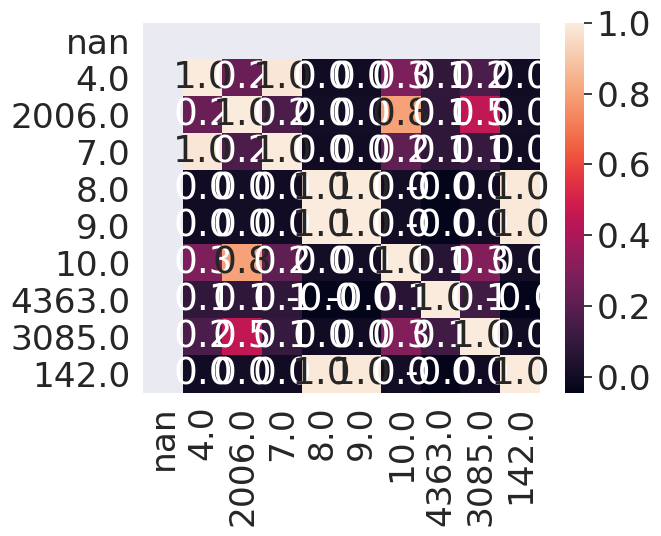

         NaN        4.0       2006.0    7.0       8.0       9.0       10.0    \
NaN          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 4.0         NaN  1.000000  0.240621  0.987210  0.002856  0.002858  0.286300   
 2006.0      NaN  0.240621  1.000000  0.164690  0.004786  0.004790  0.803560   
 7.0         NaN  0.987210  0.164690  1.000000  0.003354  0.003356  0.212440   
 8.0         NaN  0.002856  0.004786  0.003354  1.000000  1.000000  0.006233   
 9.0         NaN  0.002858  0.004790  0.003356  1.000000  1.000000  0.006235   
 10.0        NaN  0.286300  0.803560  0.212440  0.006233  0.006235  1.000000   
 4363.0      NaN  0.090030  0.081902  0.084614 -0.045109 -0.045108  0.066853   
 3085.0      NaN  0.161778  0.452889  0.102115  0.003022  0.003023  0.299751   
 142.0       NaN  0.003455  0.004864  0.003776  0.991762  0.991762  0.007915   

           4363.0    3085.0    142.0   
NaN           NaN       NaN       NaN  
 4.0     0.090030  0.161778  0.003455  

In [271]:
### Check correlations between the different financial features -- pearson correlation between the numerical variables
sns.set()
sns.set(font_scale=2.25)

all_columns = [col for col in fin_feat_labels_df.columns]

subset_cols = all_columns[:10]
subset = fin_feat_labels_df[subset_cols]

# print subset.columns
sns.heatmap(subset.corr(), fmt=".1f", annot=True)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()


print fin_feat_labels_df[subset_cols].corr()

### Interpreting the correlations
The correlation of 10 of the financial features are checked at a time, for an easier interpretation. We see that some of these financial features do have a high correlation and this would have to be taken into account while building the model. Some of the features that turn out be highly correlated are:

1) 4 (EBT Before Non Recurring Items) and 7 (earnings from continuing operations) <br>
2) 2006 (net cash used or generated in operating activities) and 10 (Total Revenue (TRIN) minus Cost Of Goods Sold, Total (COGST)) <br>
3) 8 (This item represents the aggregate of

    1. Diluted EPS - Continuing Operations 
    2. Diluted EPS - Discontinued Operations 
    3. Diluted EPS - Extraordinary Items & Accounting Change)

    and 9 (This item represents the aggregate of

    1. Basic EPS - Continuing Operations 
    2. Basic EPS - Discontinued Operations 
    3. Basic EPS - Extraordinary Items & Accounting Change)

The above highly correlated pairs are supposed to provide similar information. Therefore, the relations in the dataset do give meaningful information

In [272]:
dataset_final = temp
dataset_final.drop(u'fin_features', 1)

### Make separate column for each of the financial features in the fin_features column and drop the fin_features column
for col in fin_feat_labels_df.columns:
    dataset_final[col] = fin_feat_labels_df[col]

### Final data set for building and evaluating model - dataset_final

In [273]:
dataset_final

,SP_ENTITY_ID,COMPANYID,CALENDARYEAR,RATING_DATE,count,CALENDARQUARTER,CCST_INDUSTRY,CIQ_COMPANY_TYPE,CIQ_INDUSTRY,CIQ_NAME,...,1009.0,3058.0,33395.0,33396.0,4085.0,3064.0,379.0,1002.0,4094.0,RATING
0,100057.0,249841,2000,11/07/2000 14:54:05,2,[0],"[Oil & Gas Integrated, Exploration & Production]",[Public Company],"[Oil, Gas and Consumable Fuels]",[Hess Corporation],...,0.000,0.00,0.0,0.0,0.0000,0.000000,0.000,0.000,0.0000,14.0
1,100057.0,249841,2001,08/03/2001 15:44:18,4,[0],"[Oil & Gas Integrated, Exploration & Production]",[Public Company],"[Oil, Gas and Consumable Fuels]",[Hess Corporation],...,0.000,0.00,0.0,0.0,0.0000,0.000000,0.000,0.000,0.0000,13.0
2,100057.0,249841,2004,03/31/2004 13:07:28,2,[0],"[Oil & Gas Integrated, Exploration & Production]",[Public Company],"[Oil, Gas and Consumable Fuels]",[Hess Corporation],...,0.000,0.00,0.0,0.0,0.0000,0.000000,0.000,0.000,0.0000,15.0
3,100057.0,249841,2010,07/22/2010 12:59:04,1,[0],"[Oil & Gas Integrated, Exploration & Production]",[Public Company],"[Oil, Gas and Consumable Fuels]",[Hess Corporation],...,0.000,0.00,0.0,0.0,0.0000,0.000000,0.000,0.000,0.0000,13.0
4,100057.0,249841,2016,02/02/2016 14:48:19,1224,[4.0],"[Oil & Gas Integrated, Exploration & Production]",[Public Company],"[Oil, Gas and Consumable Fuels]",[Hess Corporation],...,2251.000,1.00,1.0,1.0,42.9350,-19.919328,-6173.000,2732.000,-131.5597,15.0
5,100167.0,252150,2001,02/13/2001 15:44:23,2,[0],[Technology - Hardware & Semiconductors],[Public Company],"[Electronic Equipment, Instruments and Compone...","[Arrow Electronics, Inc.]",...,0.000,0.00,0.0,0.0,0.0000,0.000000,0.000,0.000,0.0000,13.0
6,100167.0,252150,2002,10/10/2002 10:33:02,2,[0],[Technology - Hardware & Semiconductors],[Public Company],"[Electronic Equipment, Instruments and Compone...","[Arrow Electronics, Inc.]",...,0.000,0.00,0.0,0.0,0.0000,0.000000,0.000,0.000,0.0000,15.0
7,100190.0,126269,2014,04/10/2014 11:47:58,780,[2.0],[Technology - Software & Services],[Public Company],[IT Services],"[Automatic Data Processing, Inc.]",...,24167.600,1.88,1.0,1.0,0.1724,2.594696,1242.600,1416.600,14.8233,3.0
8,100197.0,253018,2001,10/05/2001 15:09:11,1,[0],[Technology - Hardware & Semiconductors],[Public Company],"[Electronic Equipment, Instruments and Compone...","[Avnet, Inc.]",...,0.000,0.00,0.0,0.0,0.0000,0.000000,0.000,0.000,0.0000,14.0
9,100197.0,253018,2001,11/07/2001 11:43:25,2,[0],[Technology - Hardware & Semiconductors],[Public Company],"[Electronic Equipment, Instruments and Compone...","[Avnet, Inc.]",...,0.000,0.00,0.0,0.0,0.0000,0.000000,0.000,0.000,0.0000,13.0


### Splitting Data into Training, Validation and Test Datasets

In [274]:
from sklearn.model_selection import train_test_split
### Split into train and test
train_data, test_data = train_test_split(dataset_final, test_size=0.2)
print train_data.shape
print test_data.shape

(1403, 100)
(351, 100)


### Starting by taking all the financial features as the feature set and checking which classifiers and which data preprocessing techniques work best for the prediction task

In [275]:
### Split data into training and validation data
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
### Split train data into train and dev data
X_Y_train, X_Y_dev = train_test_split(train_data, test_size=0.2)

n_classes = len(lb_enc.classes_)
print n_classes

## containing features from financial
feat_columns = fin_feat_labels_df.columns[1:-1]
## Get the train features and labels
X_train = X_Y_train[feat_columns]
Y_train = X_Y_train["RATING"]
Y_train_bin = label_binarize(Y_train, classes=range(n_classes))
## Get the dev features and labels
X_dev = X_Y_dev[feat_columns]
Y_dev = X_Y_dev["RATING"]
Y_dev_bin = label_binarize(Y_dev, classes=range(n_classes))
## Get the test features and labels
X_test = test_data[feat_columns]
Y_test = test_data["RATING"]
Y_test_bin = label_binarize(Y_test, classes=range(n_classes))

23


## Classification Pipeline

In [276]:
from sklearn.metrics import classification_report

### Data Preprocessing 

### Feature Scaling 
Used for standardizing the range of the different features. This aids in the optimization task of the classifiers. For, instance, when the classifiers use Euclidean distance to calculate distance between points, then features with different scales will have different distances and the comparison between these distances would not make any sense
Additionally, feature scaing also helps in faster convergence of gradient based optimization techniques

In [277]:
from sklearn.preprocessing import MinMaxScaler
min_max_mod = MinMaxScaler()
min_max_mod.fit(X_train)
X_train_min_max = min_max_mod.transform(X_train)
X_dev_min_max = min_max_mod.transform(X_dev)
X_test_min_max = min_max_mod.transform(X_test)
print X_train_min_max

[[6.00987065e-01 8.52174432e-03 5.79934603e-01 ... 5.79512268e-01
  0.00000000e+00 7.09837046e-01]
 [6.00987065e-01 8.52174432e-03 5.79934603e-01 ... 5.79512268e-01
  0.00000000e+00 7.09837046e-01]
 [6.00987065e-01 8.52174432e-03 5.79934603e-01 ... 5.79512268e-01
  0.00000000e+00 7.09837046e-01]
 ...
 [6.00987065e-01 8.52174432e-03 5.79934603e-01 ... 5.79512268e-01
  0.00000000e+00 7.09837046e-01]
 [6.00987065e-01 8.52174432e-03 5.79934603e-01 ... 5.79512268e-01
  0.00000000e+00 7.09837046e-01]
 [6.00902450e-01 8.52463744e-03 5.79826751e-01 ... 5.79401819e-01
  8.92490368e-05 5.62684788e-01]]


### Feature Standardization
Used to make the values of each feature in the data have zero-mean and unit-variance and it is know to be widely used as a pre-processing step in many classifiers. The mean of each feature is subtracted from each feature value and divided by the standard deviation

In [278]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_dev_scale = scaler.transform(X_dev)
X_test_scale = scaler.transform(X_test)
print X_train_scale

[[-0.03074491 -0.07882296 -0.0136541  ... -0.01017355 -0.08652768
   0.16549281]
 [-0.03074491 -0.07882296 -0.0136541  ... -0.01017355 -0.08652768
   0.16549281]
 [-0.03074491 -0.07882296 -0.0136541  ... -0.01017355 -0.08652768
   0.16549281]
 ...
 [-0.03074491 -0.07882296 -0.0136541  ... -0.01017355 -0.08652768
   0.16549281]
 [-0.03074491 -0.07882296 -0.0136541  ... -0.01017355 -0.08652768
   0.16549281]
 [-0.03388353 -0.07876836 -0.01768002 ... -0.01435425 -0.08483238
  -1.94957041]]


### Scaling sparse data (Since this data is quite sparse and we want to maintain the sparsity structure)
As per Scikit Learn documentation - Centering sparse data would destroy the sparseness structure in the data, and thus rarely is a sensible thing to do. However, it can make sense to scale sparse inputs, especially if features are on different scales.

In [279]:
### Convert the feature matrices to sparse matrices
from scipy import sparse
from sklearn.preprocessing import MaxAbsScaler
sparse_X_train = sparse.csr_matrix(X_train)
sparse_X_dev = sparse.csr_matrix(X_dev)
sparse_X_test = sparse.csr_matrix(X_test)

min_max_mod = MaxAbsScaler()
min_max_mod.fit(sparse_X_train)
sparse_X_train_min_max = min_max_mod.transform(sparse_X_train)
sparse_X_dev_min_max = min_max_mod.transform(sparse_X_dev)
sparse_X_test_min_max = min_max_mod.transform(sparse_X_test)

### Dimensionality Reduction with PCA
The financial features present a set of highly sparse feature set. Also, there is high correlation between some of the features as mentioned above. In order to overcome this problem we can perform dimensionality reduction using Pricipal Component Analysis or PCA. PCA is a very widely used technique for data preprocessing in Machine Learning. It uses orthogonal transformation to convert a set of possibly highly correlated variables into a set of linearly uncorrelated features called principal components. In this manner, it also amounts to reducing noise in the data, while maintaining the important information

In [280]:
import sklearn.decomposition as skdc ##Includes Principal Component Analysis, a method of dimensionality reduction
import sklearn.pipeline as skpl ##Convenient module for calculating PCs and using them in logistic regression

pca_m = skdc.PCA()
X_train_scale_PCA = pca_m.fit_transform(X_train_scale)

In [281]:
variance = pd.Series(pca_m.explained_variance_ratio_) 
print variance

num_PCs = 25
print "First", str(num_PCs), "account for 96% of the variance"
print "Therefore, we can disregard the rest"
print (sum(variance[0:num_PCs]))

0     2.636350e-01
1     1.072656e-01
2     9.645667e-02
3     8.131179e-02
4     7.022008e-02
5     4.323982e-02
6     3.170449e-02
7     2.803022e-02
8     2.772076e-02
9     2.453745e-02
10    2.103110e-02
11    1.960565e-02
12    1.804903e-02
13    1.612583e-02
14    1.479984e-02
15    1.411070e-02
16    1.361027e-02
17    1.288212e-02
18    1.218570e-02
19    1.168237e-02
20    1.004056e-02
21    8.720085e-03
22    8.248684e-03
23    7.556465e-03
24    6.718639e-03
25    5.903563e-03
26    4.935280e-03
27    4.649789e-03
28    3.781849e-03
29    2.607325e-03
          ...     
40    1.338024e-04
41    1.075797e-04
42    8.782831e-05
43    5.120107e-05
44    3.436575e-05
45    3.286475e-05
46    2.763513e-05
47    2.198131e-05
48    1.443042e-05
49    1.150390e-05
50    8.266420e-06
51    4.751372e-06
52    2.076585e-06
53    6.551201e-07
54    3.555734e-07
55    2.743210e-07
56    1.939069e-07
57    1.643264e-07
58    1.020553e-07
59    3.707446e-08
60    2.708722e-08
61    8.0639

### Feature ranking with recursive feature elimination
This fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s feature_importances_ attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in the model.

In [282]:

model = LogisticRegression()

rfe = RFE(model, 10)
fit = rfe.fit(X_train_min_max, Y_train)

In [283]:
print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num Features: 10
Selected Features: [ True False False  True  True False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False  True False False False
  True False False False False False False False False False False False
 False False False  True  True False False  True False False False False
 False False False False False False False False False  True]
Feature Ranking: [ 1 28  9  1  1 61  3 44 18  5 50 46 51  1  8 57 37  7 11 39 52 17 23 35
 58 21 24 26 25 14 16 36  1 13 43  4  1 55 33 41 47 19 10 49 40 34 48 20
  6 12 59  1  1 29  2  1 32 30 56 53 60 54 45 27 38 31 22 15 42  1]


### Model Implementations

### Logistic Regression Model
Testing a vanilla Logistic Regression Model

In [284]:
from sklearn.multiclass import OneVsRestClassifier
model1 = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs', max_iter = 1000,
                         multi_class='multinomial', penalty='l2'))
model1.fit(X_train_scale, Y_train_bin)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [285]:
Y_predict = model1.predict(X_train_scale)
print model1.score(X_train_scale, Y_train_bin)
# model1.classes_

0.045454545454545456


In [ ]:
c_matrix = confusion_matrix(Y_train, Y_predict)

print lb_enc.classes_
# ### Visualizing the confusion matrix
df_cm = pd.DataFrame(c_matrix, index = [i for i in model1.classes_],
                    columns = [i for i in model1.classes_])
plt.figure(figsize = (20,20))
sns.set(font_scale=1.00)
sns.heatmap(df_cm, annot=True)

### Logistic Regression with PCA and standardization

In [287]:
from sklearn.pipeline import Pipeline
model1 = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs', max_iter = 100,
                         multi_class='multinomial', penalty='l2'))
pca = skdc.PCA(65)
pipe = Pipeline([('pca', pca), ('logistic', model1)])
pipe.fit(X_train_scale, Y_train_bin)
print pipe.score(X_train_scale, Y_train_bin)

### PCA does not give an improvement

0.045454545454545456


In the above experiment it is seen the PCA does not improve the model

In [288]:
#### Checking label distribution in the training data
labels_percent_train = 100 * Y_train.value_counts() / len(Y_train)
print labels_percent_train
print type(labels_percent_train)
labels_percent_train_dict = labels_percent_train.to_dict()
print labels_percent_train_dict
labels_percent_dict_sort = sorted(labels_percent_train_dict.iteritems(), key=lambda (k,v): (v,k))
print labels_percent_dict_sort
labels_sort = dict(labels_percent_dict_sort)
class_weight_dict = dict()

#Assign inverse of the frequency of the class as the class weight, so that classes with smaller data points are given more weight
## This is one way of dealing with imbalanced datasets
for label in labels_sort:
    class_weight_dict[label] = 1.0/labels_sort[label]
print class_weight_dict

7.0     13.814617
9.0     10.695187
8.0     10.249554
12.0     7.843137
10.0     7.219251
11.0     7.130125
15.0     6.862745
13.0     5.882353
14.0     4.901961
2.0      4.456328
18.0     4.367201
1.0      2.584670
22.0     2.317291
0.0      2.049911
5.0      1.782531
21.0     1.693405
17.0     1.693405
16.0     1.693405
19.0     0.891266
20.0     0.891266
3.0      0.445633
4.0      0.445633
6.0      0.089127
Name: RATING, dtype: float64
<class 'pandas.core.series.Series'>
{0.0: 2.049910873440285, 1.0: 2.584670231729055, 2.0: 4.45632798573975, 3.0: 0.44563279857397503, 4.0: 0.44563279857397503, 5.0: 1.7825311942959001, 6.0: 0.08912655971479501, 7.0: 13.814616755793226, 8.0: 10.249554367201426, 9.0: 10.695187165775401, 10.0: 7.219251336898396, 11.0: 7.1301247771836005, 12.0: 7.8431372549019605, 13.0: 5.882352941176471, 14.0: 4.901960784313726, 15.0: 6.862745098039215, 16.0: 1.6934046345811051, 17.0: 1.6934046345811051, 18.0: 4.367201426024955, 19.0: 0.8912655971479501, 20.0: 0.89126559

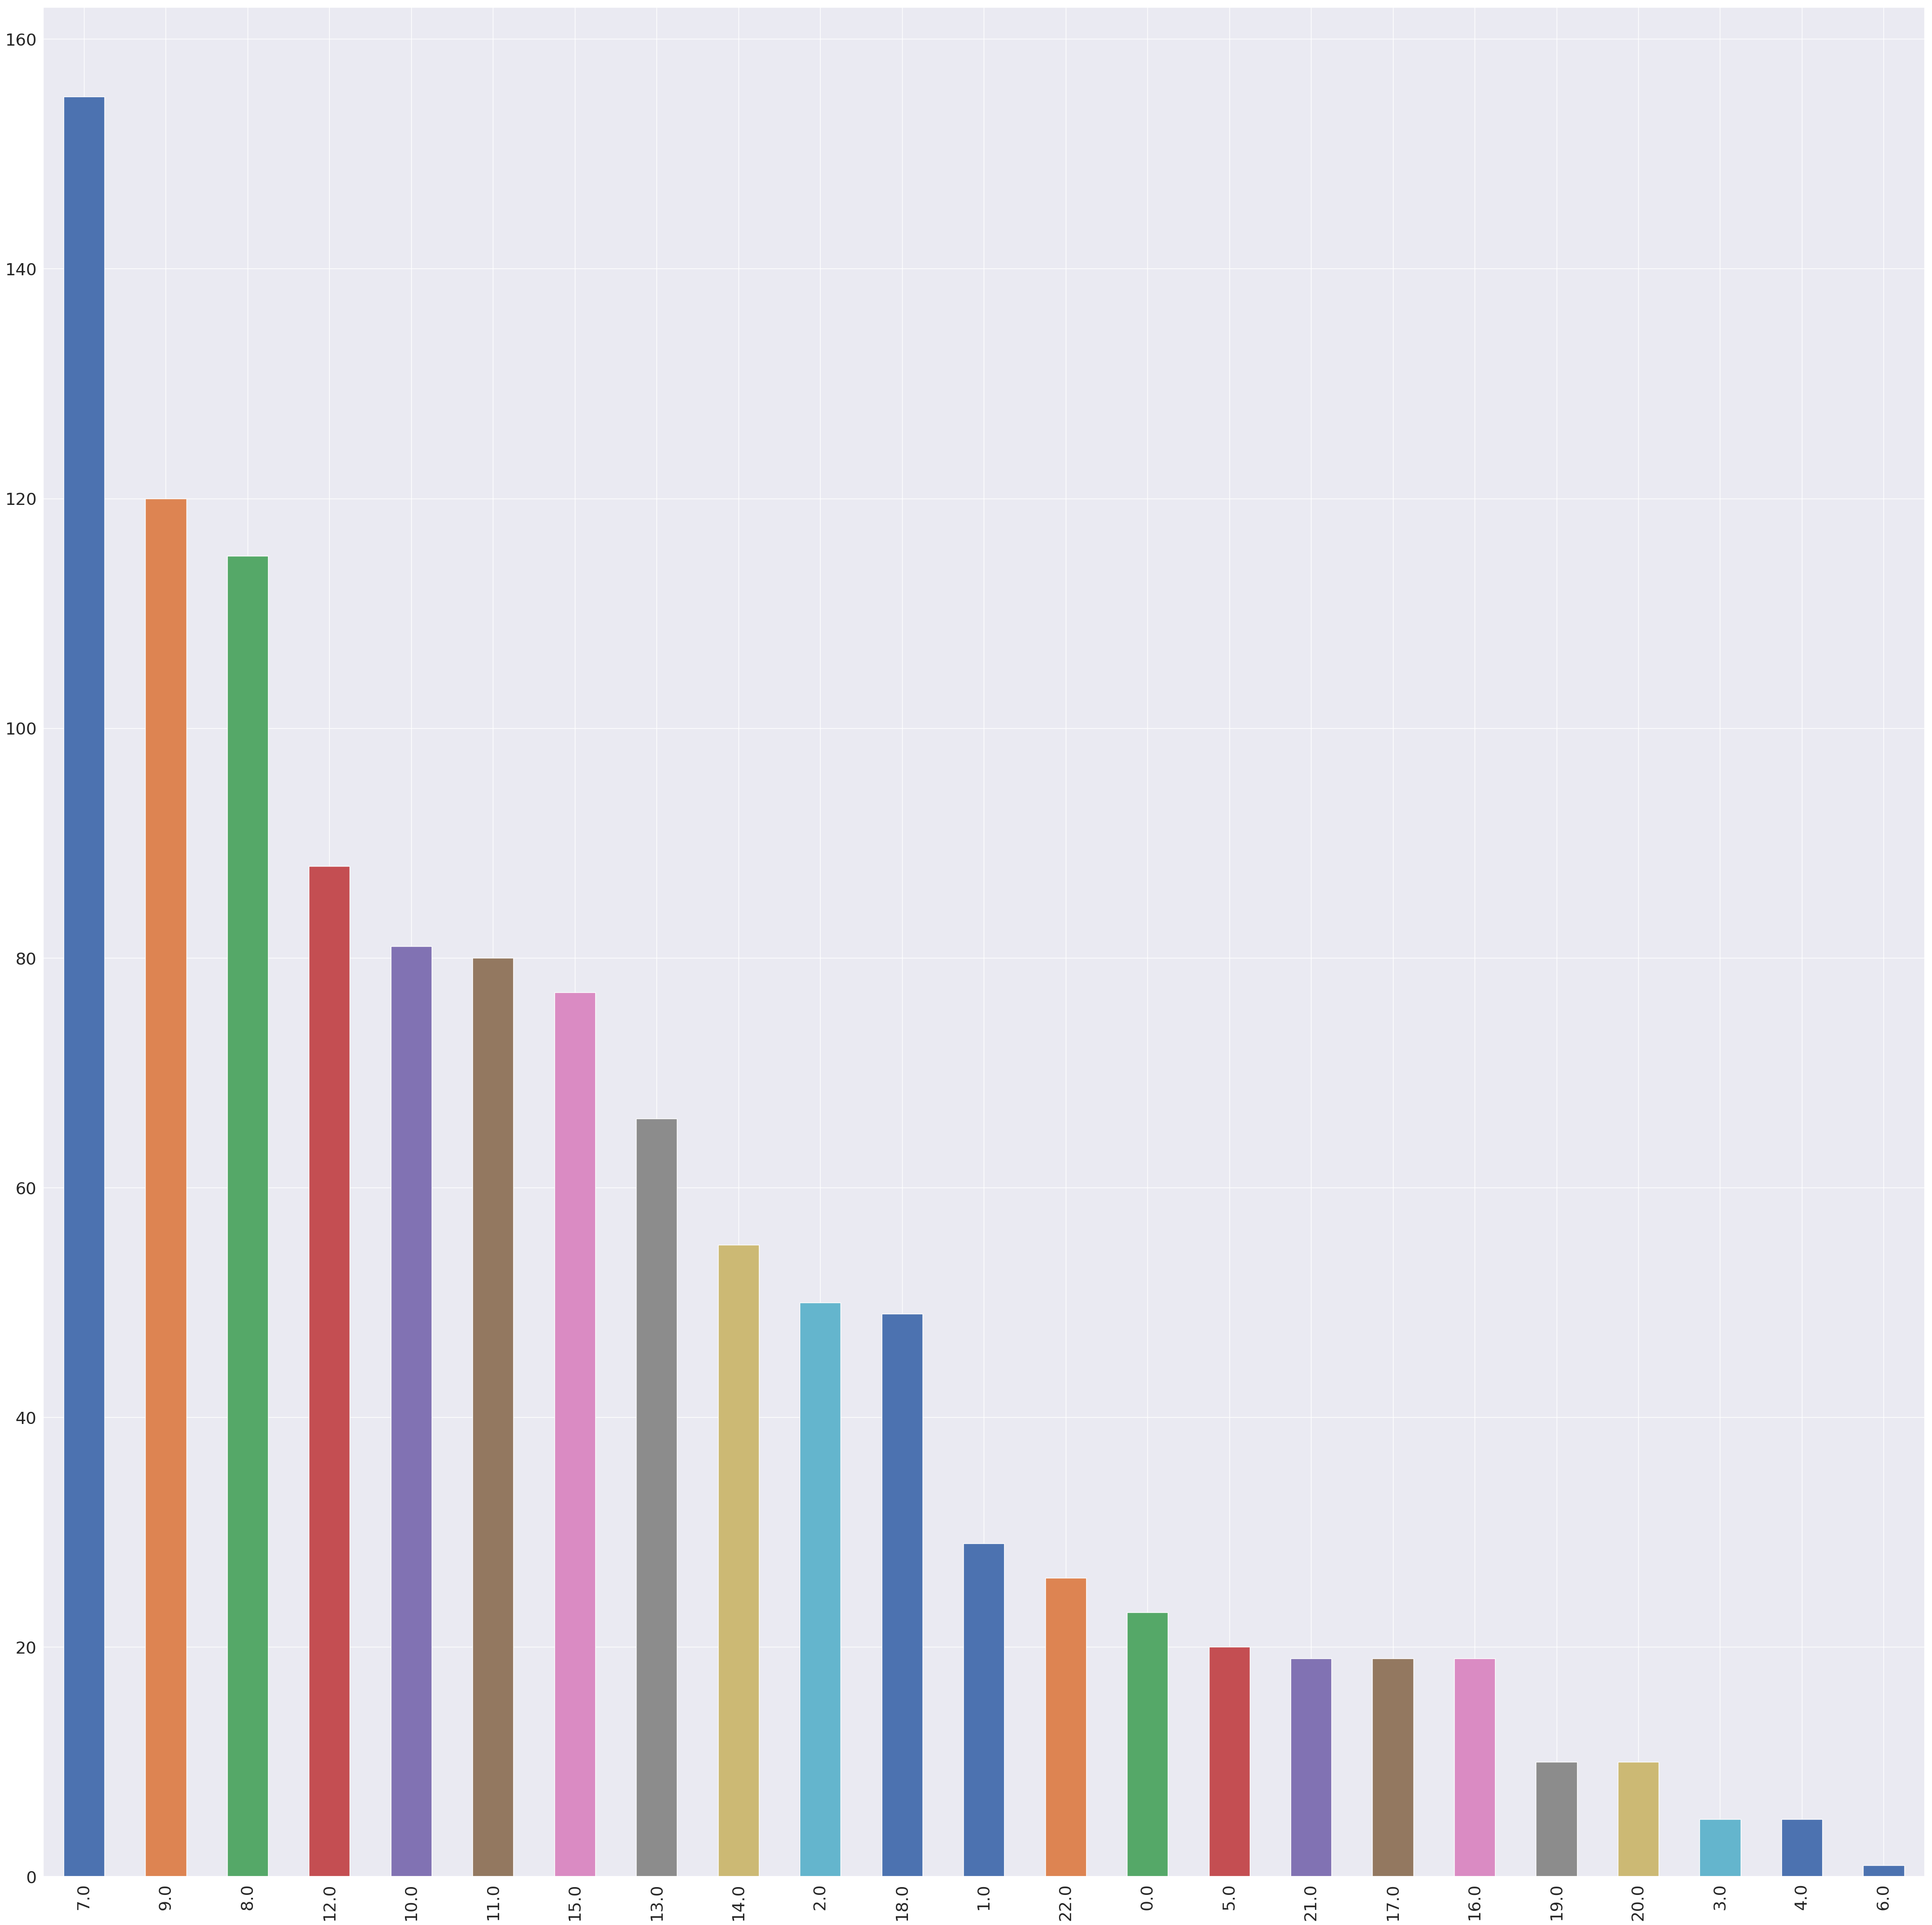

In [289]:
Y_train.value_counts().plot("bar")

### Gradient Boosting Model
On Gradient Boosting algorithm, check which data transformation works best

#### Initializing Gradient booting algorithms for testing with different data normalization techniques that were defined above

In [290]:
from sklearn.ensemble import GradientBoostingClassifier

gbMod = OneVsRestClassifier(GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3, 
                                   init=None, random_state=None, max_features=None, verbose=0))
gbMod1 = OneVsRestClassifier(GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0))
gbMod2 = OneVsRestClassifier(GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0))
gbMod3 = OneVsRestClassifier(GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0))
gbMod4 = OneVsRestClassifier(GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0))
gbMod5 = OneVsRestClassifier(GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0))

### Gradient Boosting with the best features from XGBoost and min max abs scaling
gbMod6 = OneVsRestClassifier(GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0))
### Gradient Boosting with the best features from ExtraTreesClassifier and min max abs scaling
gbMod7 = OneVsRestClassifier(GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                   max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0))

In [291]:
# X_train == X_train_min_max

In [292]:
gbMod1.fit(X_train, Y_train_bin)
gbMod2.fit(X_train_min_max, Y_train_bin)
gbMod3.fit(X_train_scale, Y_train_bin)
gbMod4.fit(sparse_X_train_min_max, Y_train_bin)


OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          n_jobs=None)

In [293]:
Y_pred_train1 = gbMod1.predict(X_train)
Y_pred_train_pro1 = gbMod1.predict_proba(X_train)
Y_pred_dev1 = gbMod1.predict(X_dev)
Y_pred_dev_pro1 = gbMod1.predict_proba(X_dev)

Y_pred_train2 = gbMod2.predict(X_train_min_max)
Y_pred_train_pro2 = gbMod2.predict_proba(X_train_min_max)
Y_pred_dev2 = gbMod2.predict(X_dev_min_max)
Y_pred_dev_pro2 = gbMod2.predict_proba(X_dev_min_max)

Y_pred_train3 = gbMod3.predict(X_train_scale)
Y_pred_train_pro3 = gbMod3.predict_proba(X_train_scale)
Y_pred_dev3 = gbMod3.predict(X_dev_scale)
Y_pred_dev_pro3 = gbMod3.predict_proba(X_dev_scale)

Y_pred_train4 = gbMod4.predict(sparse_X_train_min_max)
Y_pred_train_pro4 = gbMod4.predict_proba(sparse_X_train_min_max)
Y_pred_dev4 = gbMod4.predict(sparse_X_dev_min_max)
Y_pred_dev_pro4 = gbMod4.predict_proba(sparse_X_dev_min_max)



In [294]:
from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc


In [295]:
print gbMod1.score(X_train, Y_train_bin)
print gbMod1.score(X_dev, Y_dev_bin)
print roc_auc_score(Y_train_bin,Y_pred_train_pro1, average='macro', sample_weight=None)
# print roc_auc_score(Y_dev_bin, Y_pred_dev_pro1, average='macro', sample_weight=None)

print

print gbMod2.score(X_train_min_max, Y_train_bin)
print gbMod2.score(X_dev_min_max, Y_dev_bin)
print roc_auc_score(Y_train_bin, Y_pred_train_pro2, average='macro', sample_weight=None)
# print roc_auc_score(Y_dev_bin, Y_pred_dev_pro2, average='macro', sample_weight=None)

print

print gbMod3.score(X_train_scale, Y_train_bin)
print gbMod3.score(X_dev_scale, Y_dev_bin)
print roc_auc_score(Y_train_bin, Y_pred_train_pro3, average='macro', sample_weight=None)
# print roc_auc_score(Y_dev_bin,Y_pred_dev_pro3, average='macro', sample_weight=None)

print

print gbMod4.score(sparse_X_train_min_max, Y_train_bin)
print gbMod4.score(sparse_X_dev_min_max, Y_dev_bin)
print roc_auc_score(Y_train_bin,Y_pred_train_pro4, average='macro', sample_weight=None)
# print roc_auc_score(Y_dev_bin, Y_pred_dev_pro4, average='macro', sample_weight=None)


### Observed that Sparse Max Abs scaling gives the best results

0.15775401069518716
0.0
0.697319338870279

0.1586452762923351
0.0035587188612099642
0.697319338870279

0.15775401069518716
0.0
0.697319338870279

0.15775401069518716
0.0035587188612099642
0.697319338870279


### Run model with most important features obtained from XGBoost and ExtraTrees Classifiers using sparse Max Abs scaling

### Feature importance with XGBoost
XGBoost model automatically calculates feature importance

In [296]:
# fit model no training data
from xgboost import XGBClassifier
model = XGBClassifier()
# feat_columns = fin_feat_labels_df.columns[1:-1]
model.fit(sparse_X_train_min_max, Y_train)
# feature importance
print(len(model.feature_importances_))
print (len(feat_columns))

70
70


Features sorted by their importance
[(4.0, 0.07441373), (4424.0, 0.035241712), (4190.0, 0.02960828), (10.0, 0.028822219), (4183.0, 0.027774138), (3053.0, 0.027250098), (4375.0, 0.026333028), (4042.0, 0.025808988), (2006.0, 0.025022928), (3028.0, 0.023057776), (1275.0, 0.022402724), (4194.0, 0.022271715), (3217.0, 0.022009695), (1094.0, 0.020568583), (4034.0, 0.019913534), (4196.0, 0.019782523), (4085.0, 0.019520503), (4383.0, 0.019258482), (4422.0, 0.018734442), (4051.0, 0.018734442), (3085.0, 0.018472422), (2021.0, 0.018341413), (4128.0, 0.018210402), (28.0, 0.018079393), (4192.0, 0.016245252), (4020.0, 0.01585222), (4204.0, 0.015721211), (4121.0, 0.01545919), (1096.0, 0.01545919), (4175.0, 0.01454212), (4193.0, 0.0144111095), (4423.0, 0.014280099), (4030.0, 0.014280099), (4189.0, 0.014149089), (4199.0, 0.013756059), (4382.0, 0.013625049), (4173.0, 0.0127079785), (8.0, 0.012576968), (1006.0, 0.012052928), (1002.0, 0.011921918), (4185.0, 0.011790908), (1007.0, 0.011790908), (4047.0, 0.

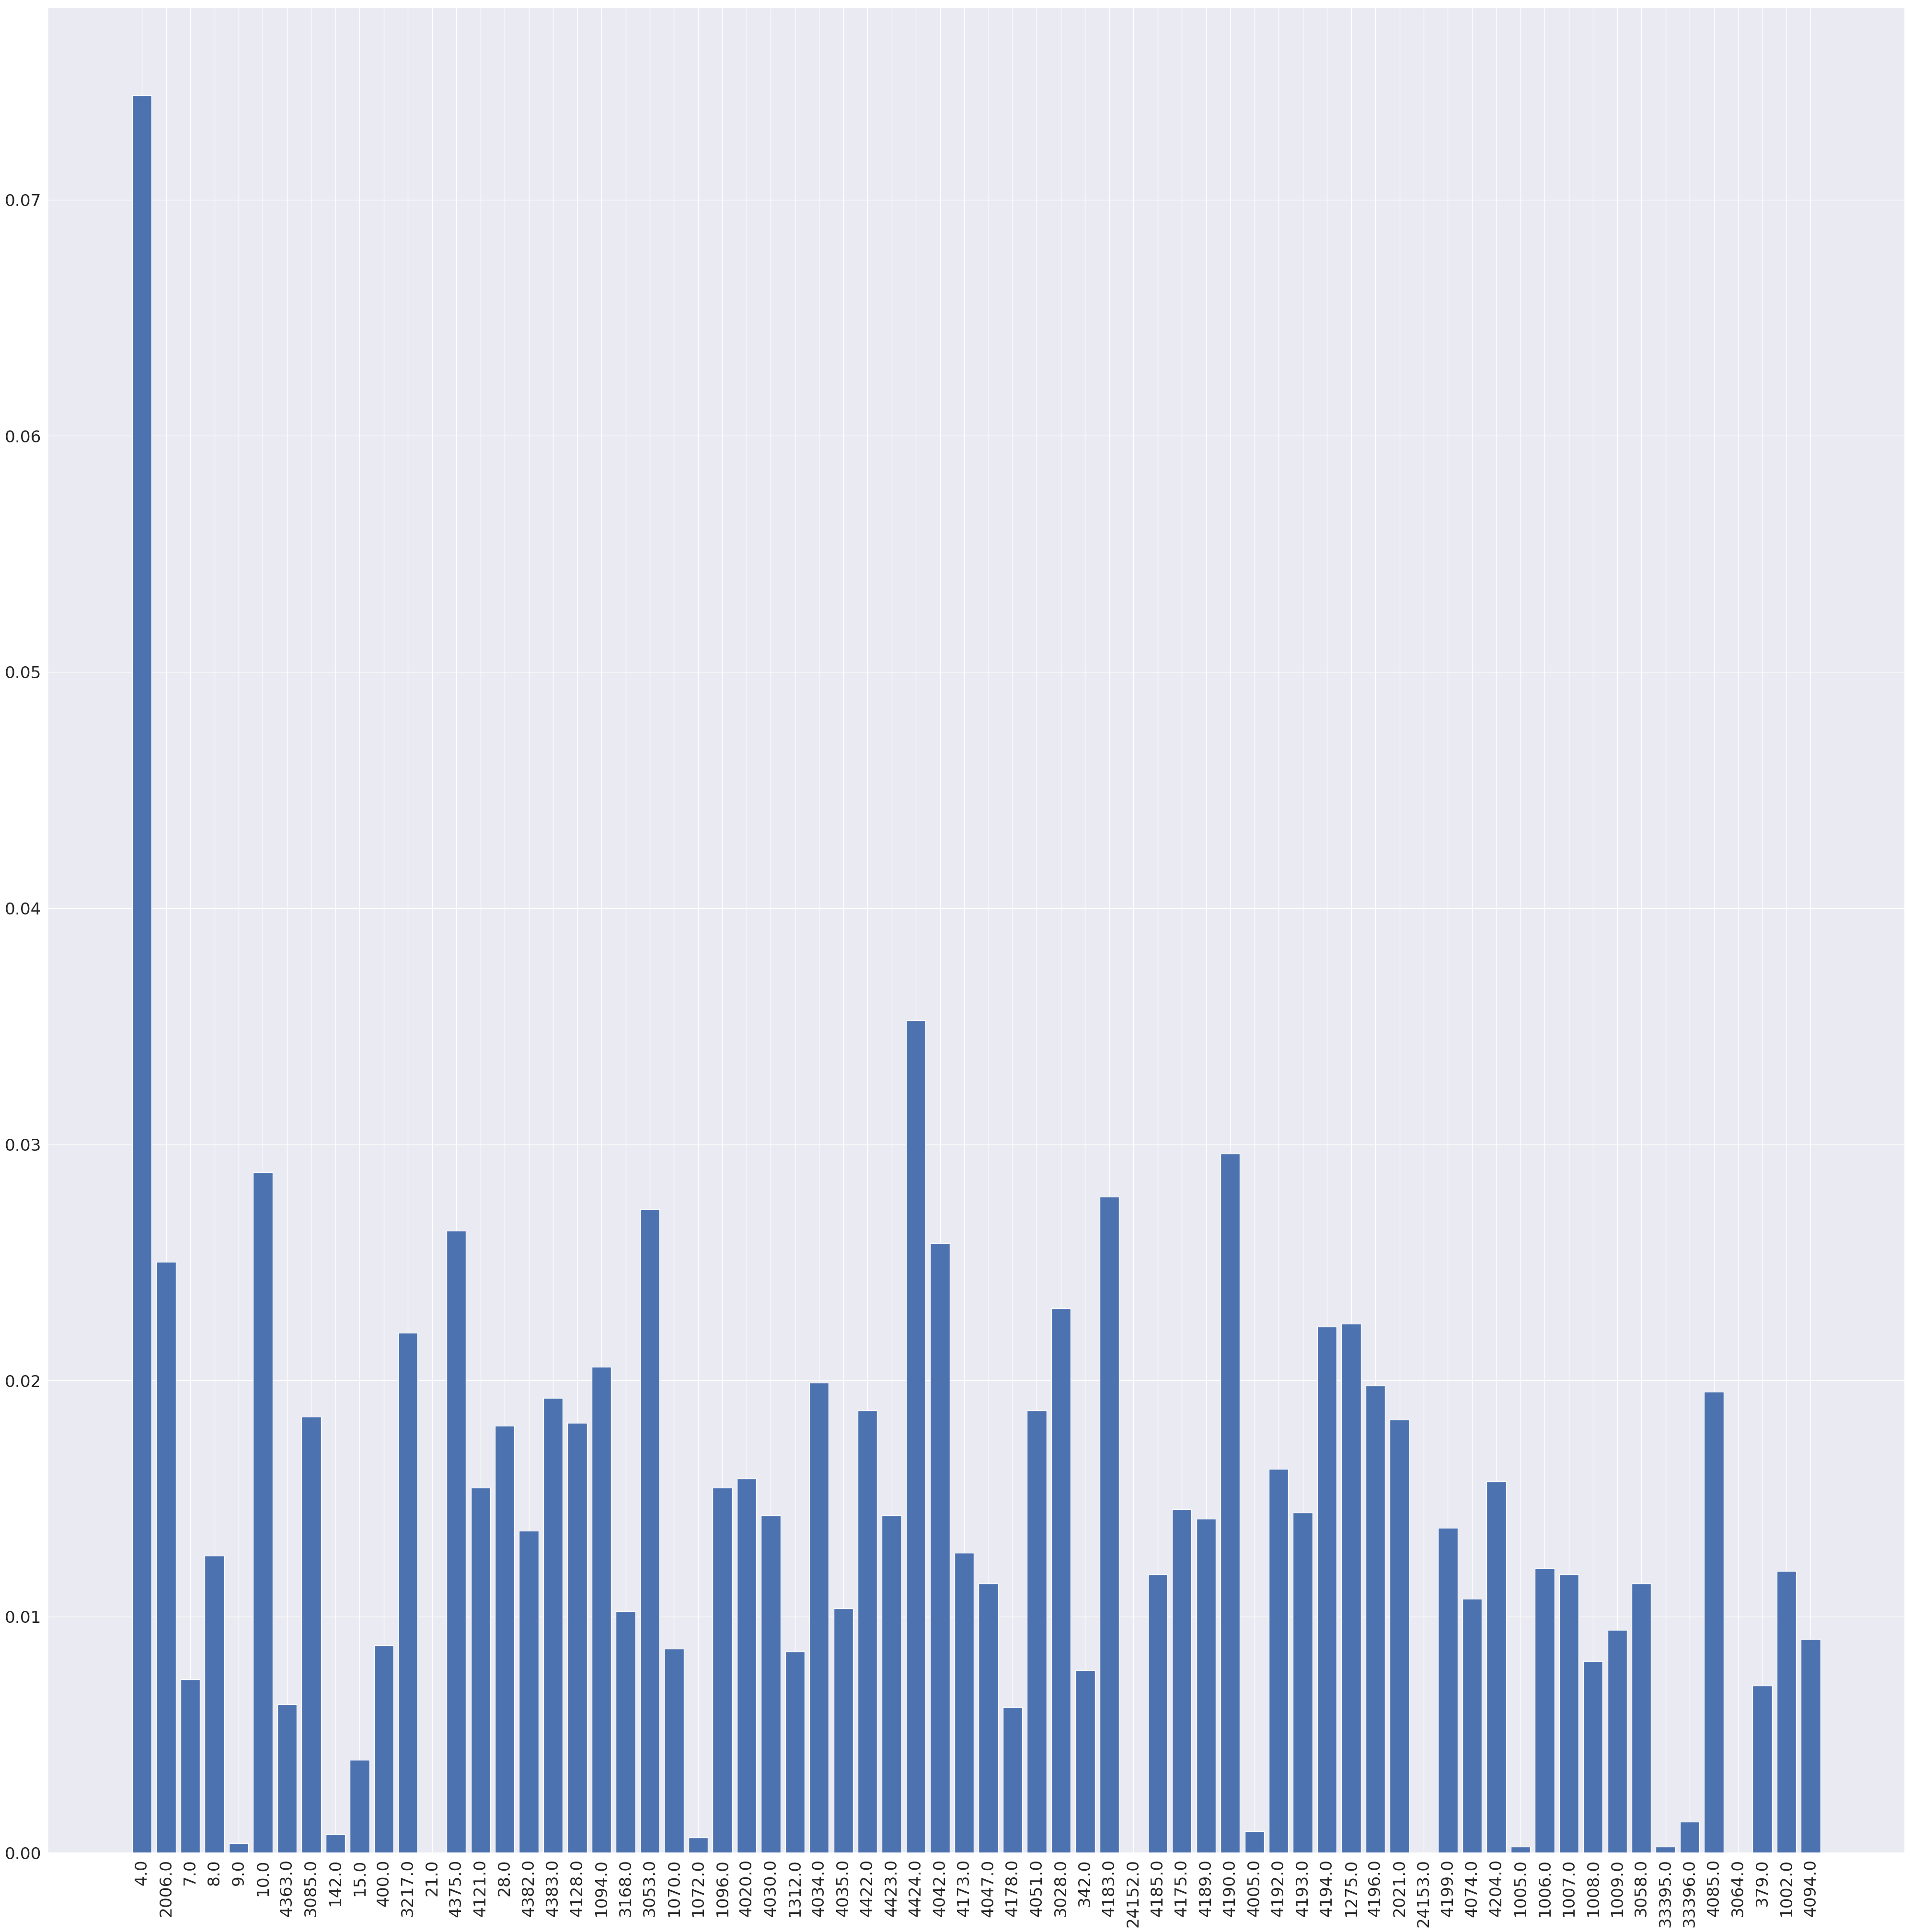

In [297]:
feature_imp = model.feature_importances_
feature_imp_dict = dict()

for i in range(len(feat_columns)):
    
    feature_imp_dict[feat_columns[i]] = feature_imp[i]

feature_imp_sort = sorted(feature_imp_dict.iteritems(), key=lambda (k,v): (v,k), reverse=True)
# plot
print "Features sorted by their importance"
print feature_imp_sort
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(range(len(feat_columns)),feat_columns, rotation=90)
plt.savefig("feat_imp_xgboost.png")
pyplot.show()

In [298]:
### Taking the 20 most important features obtained from XGBoost
imp_20_xgb = zip(*feature_imp_sort[:20])[0]
print imp_20_xgb

X_train_xgb = X_train[list(imp_20_xgb)]
X_dev_xgb = X_dev[list(imp_20_xgb)]
X_test_xgb = X_test[list(imp_20_xgb)]
print X_train_xgb.columns

sparse_X_train_xgb = sparse.csr_matrix(X_train_xgb)
sparse_X_dev_xgb = sparse.csr_matrix(X_dev_xgb)
sparse_X_test_xgb = sparse.csr_matrix(X_test_xgb)
# sparse_X_test_xgb = sparse.csr_matrix(X_test_xgb)

min_max_mod = MaxAbsScaler()
min_max_mod.fit(sparse_X_train_xgb)
sparse_X_train_xgb = min_max_mod.transform(sparse_X_train_xgb)
sparse_X_dev_xgb = min_max_mod.transform(sparse_X_dev_xgb)
# sparse_X_test_xgb = min_max_mod.transform(sparse_X_test_xgb)

(4.0, 4424.0, 4190.0, 10.0, 4183.0, 3053.0, 4375.0, 4042.0, 2006.0, 3028.0, 1275.0, 4194.0, 3217.0, 1094.0, 4034.0, 4196.0, 4085.0, 4383.0, 4422.0, 4051.0)
Index([   4.0, 4424.0, 4190.0,   10.0, 4183.0, 3053.0, 4375.0, 4042.0, 2006.0,
       3028.0, 1275.0, 4194.0, 3217.0, 1094.0, 4034.0, 4196.0, 4085.0, 4383.0,
       4422.0, 4051.0],
      dtype='object')


In [299]:
gbMod5.fit(sparse_X_train_xgb, Y_train)

OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          n_jobs=None)

In [300]:
print gbMod5.score(sparse_X_train_xgb, Y_train)
print gbMod5.score(sparse_X_dev_xgb, Y_dev)
Y_pred_train5 = gbMod5.predict(sparse_X_train_xgb)
Y_pred_train_pro5 = gbMod5.predict_proba(sparse_X_train_xgb)
Y_pred_dev5 = gbMod5.predict(sparse_X_dev_xgb)
Y_pred_dev_pro5 = gbMod5.predict_proba(sparse_X_dev_xgb)

print roc_auc_score(Y_train_bin,Y_pred_train_pro5, average='macro', sample_weight=None)

0.3057040998217469
0.14590747330960854
0.697319338870279


### Feature importance with ExtraTreesClassifier


In [301]:
model = ExtraTreesClassifier()
# feat_columns = fin_feat_labels_df.columns[1:-1]
model.fit(sparse_X_train_min_max, Y_train)
# feature importance
print(len(model.feature_importances_))
print (len(feat_columns))

70
70


Features sorted by their importance
[(1007.0, 0.024895244569870807), (4042.0, 0.023427352331087736), (4189.0, 0.02063692687613068), (10.0, 0.020439360384435515), (4074.0, 0.020245216255073282), (4193.0, 0.019911928281259608), (4192.0, 0.019221713261145718), (4094.0, 0.019015416898766336), (1002.0, 0.018956224174131394), (4085.0, 0.018872014127658578), (4194.0, 0.017734305025872286), (1006.0, 0.017680348646894398), (2021.0, 0.017565951678019283), (4047.0, 0.017456692099435355), (9.0, 0.017196929974390526), (4363.0, 0.017102948683996956), (3053.0, 0.017072536469294994), (24153.0, 0.01705583218088185), (4128.0, 0.016798707925900568), (4375.0, 0.01675306466470846), (379.0, 0.016725830704551792), (400.0, 0.016721308843189623), (4190.0, 0.01637016087784899), (4173.0, 0.0160612259368567), (4383.0, 0.016057780259727882), (4196.0, 0.01603694590449729), (1008.0, 0.015862114152213103), (4183.0, 0.015523316364533107), (1096.0, 0.01548398694287445), (1094.0, 0.01541380520452365), (2006.0, 0.0151165

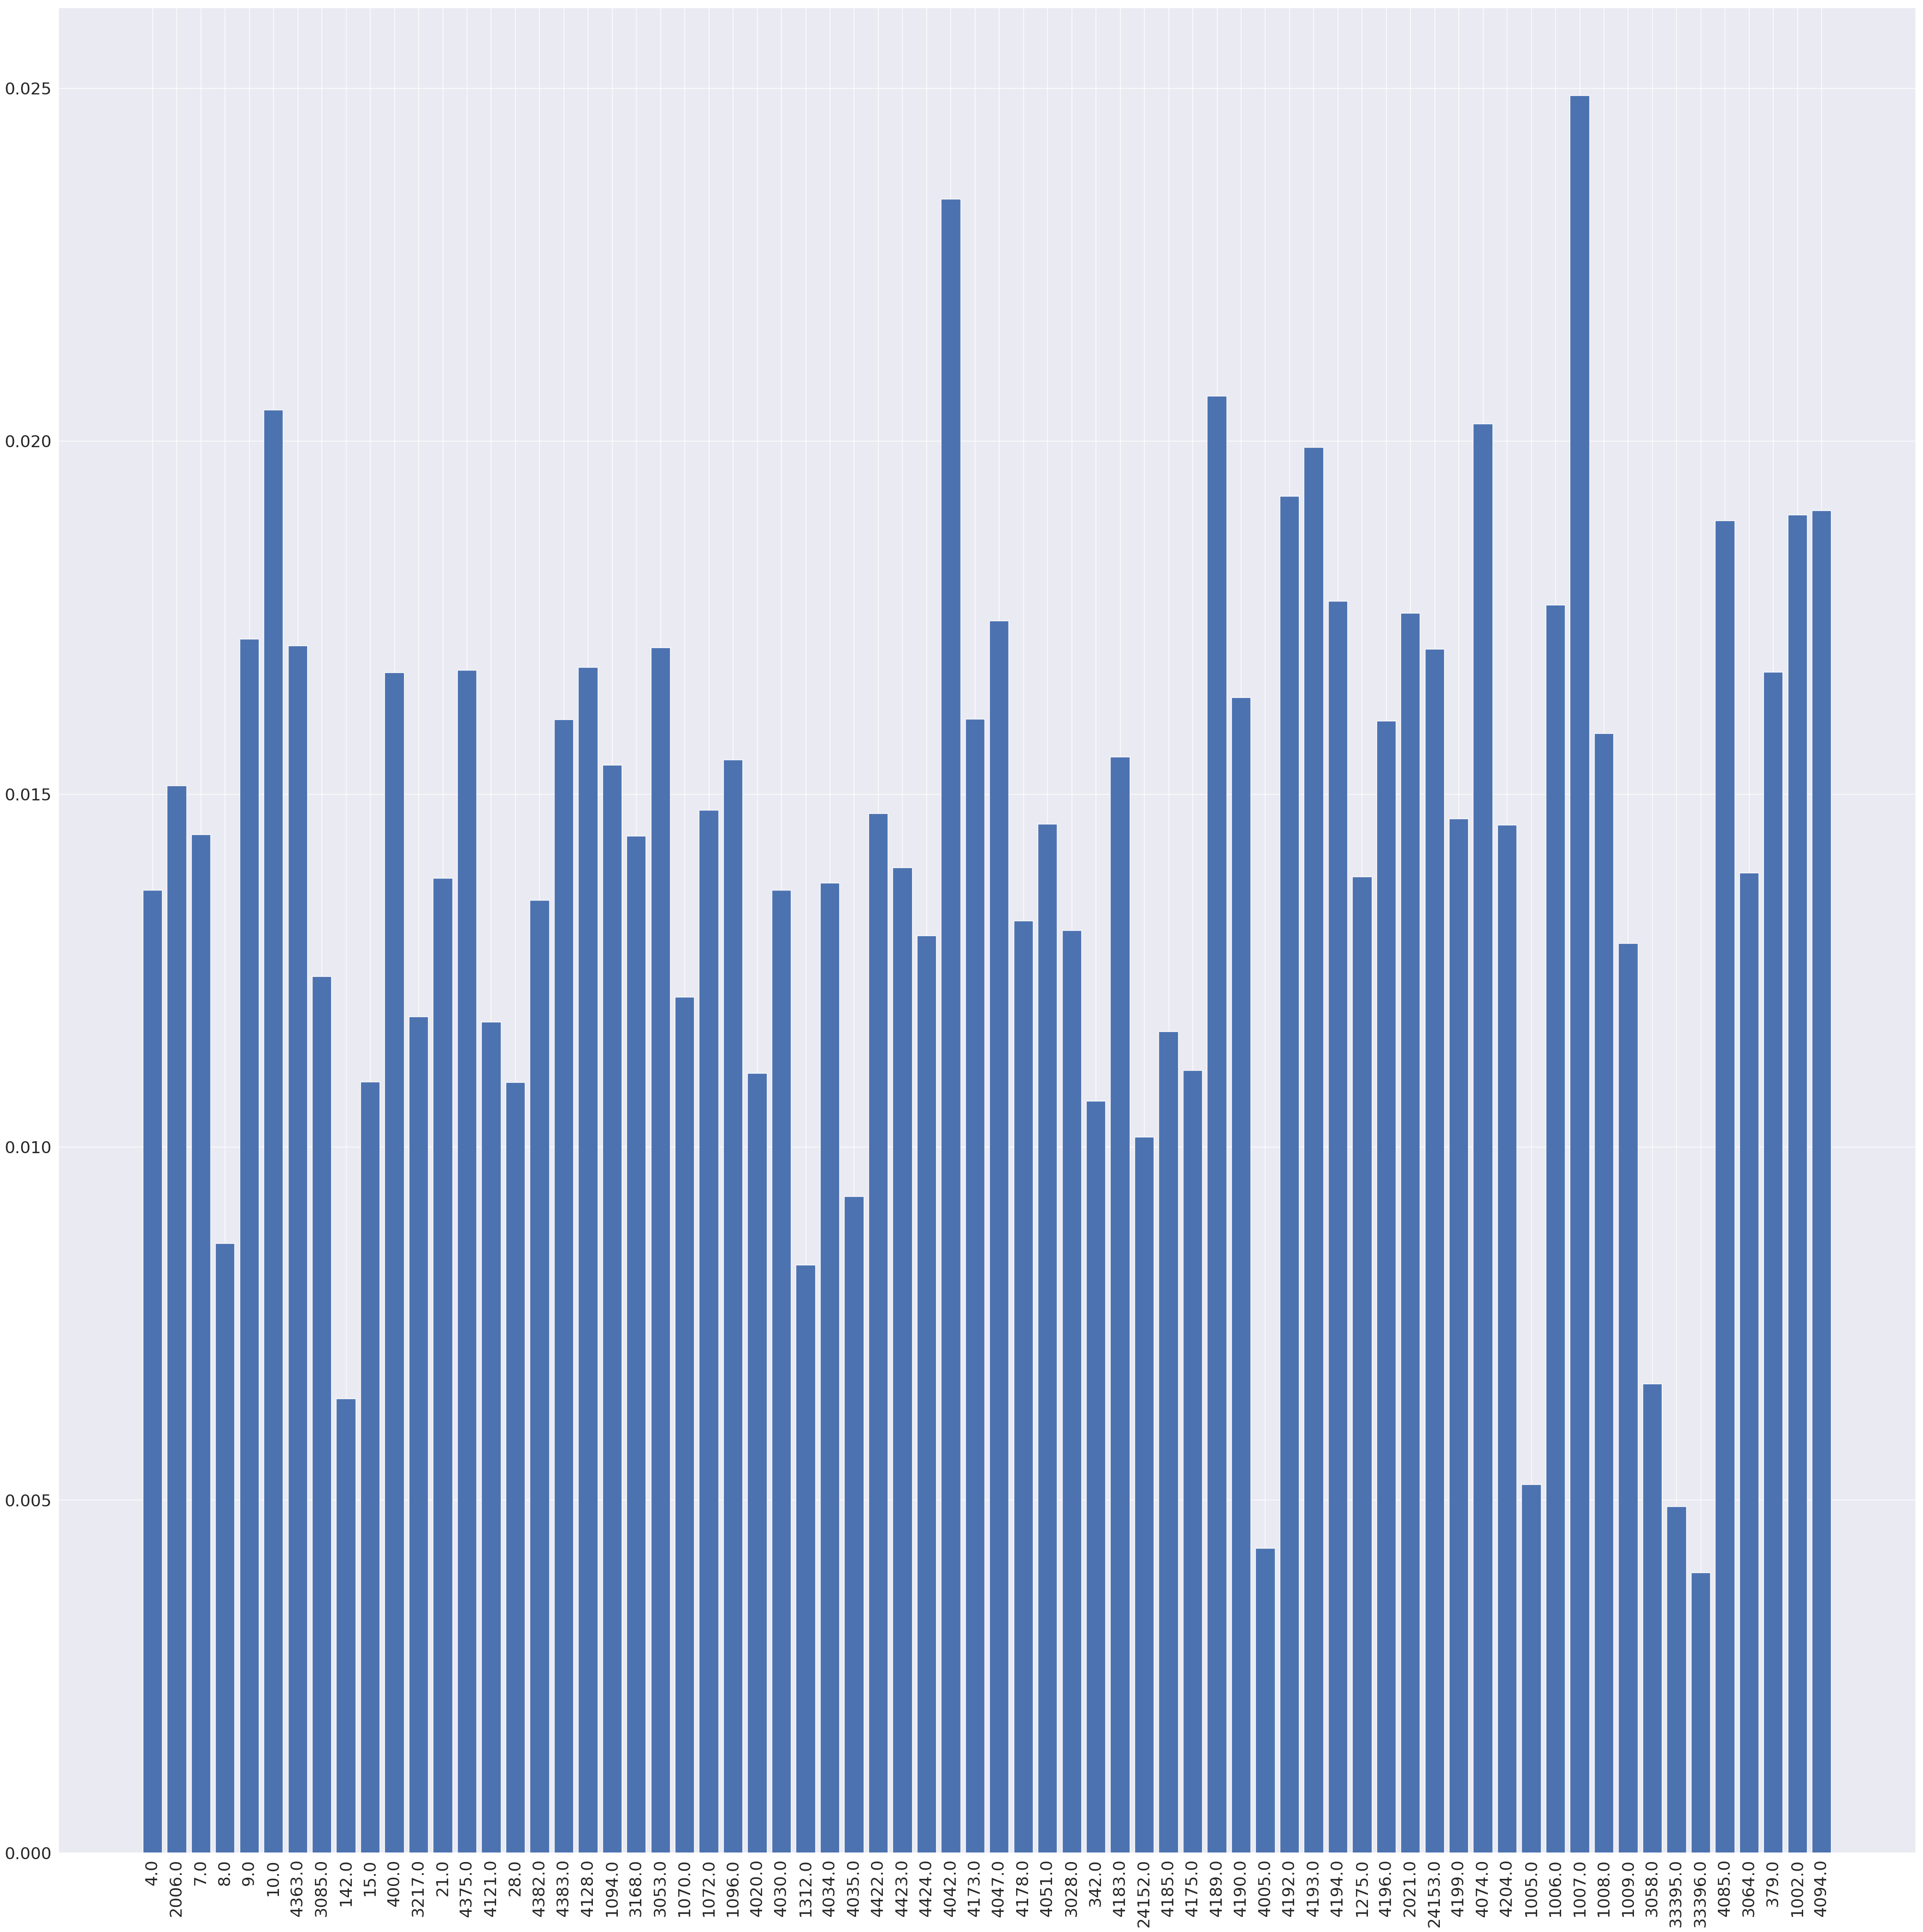

In [302]:
feature_imp = model.feature_importances_
feature_imp_dict = dict()

for i in range(len(feat_columns)):
    
    feature_imp_dict[feat_columns[i]] = feature_imp[i]

feature_imp_sort = sorted(feature_imp_dict.iteritems(), key=lambda (k,v): (v,k), reverse=True)
# plot
print "Features sorted by their importance"
print feature_imp_sort
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(range(len(feat_columns)),feat_columns, rotation=90)
plt.savefig("feat_imp_extra_trees.png")
pyplot.show()

In [303]:
### Taking the 20 most important features obtained from XGBoost
imp_20_extra = zip(*feature_imp_sort[:20])[0]
print imp_20_extra

X_train_extra = X_train[list(imp_20_extra)]
X_dev_extra = X_dev[list(imp_20_extra)]

print X_train_extra.columns

sparse_X_train_extra = sparse.csr_matrix(X_train_extra)
sparse_X_dev_extra = sparse.csr_matrix(X_dev_extra)
# sparse_X_test_xgb = sparse.csr_matrix(X_test_xgb)

min_max_mod = MaxAbsScaler()
min_max_mod.fit(sparse_X_train_extra)
sparse_X_train_extra = min_max_mod.transform(sparse_X_train_extra)
sparse_X_dev_extra = min_max_mod.transform(sparse_X_dev_extra)
# sparse_X_test_xgb = min_max_mod.transform(sparse_X_test_xgb)

(1007.0, 4042.0, 4189.0, 10.0, 4074.0, 4193.0, 4192.0, 4094.0, 1002.0, 4085.0, 4194.0, 1006.0, 2021.0, 4047.0, 9.0, 4363.0, 3053.0, 24153.0, 4128.0, 4375.0)
Index([ 1007.0,  4042.0,  4189.0,    10.0,  4074.0,  4193.0,  4192.0,  4094.0,
        1002.0,  4085.0,  4194.0,  1006.0,  2021.0,  4047.0,     9.0,  4363.0,
        3053.0, 24153.0,  4128.0,  4375.0],
      dtype='object')


In [304]:
gbMod6.fit(sparse_X_train_extra, Y_train_bin)

OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          n_jobs=None)

In [305]:
Y_pred_train6 = gbMod6.predict(sparse_X_train_extra)
Y_pred_train_pro6 = gbMod6.predict_proba(sparse_X_train_extra)
Y_pred_dev6 = gbMod6.predict(sparse_X_dev_extra)
Y_pred_dev_pro6 = gbMod6.predict_proba(sparse_X_dev_extra)

print roc_auc_score(Y_train_bin,Y_pred_train_pro6, average='macro', sample_weight=None)
print gbMod6.score(sparse_X_train_extra, Y_train_bin)
print gbMod6.score(sparse_X_dev_extra, Y_dev_bin)

0.697319338870279
0.15775401069518716
0.0


### Inference
The important features found with Xgboost perform better than the important features found with Extra Trees Classifier due to higher accuracy values for the training and development set. Therefore, the importance features found with Xgboost are used for the rest of the experiments

### Adaboost Model

In [306]:
from sklearn.ensemble import AdaBoostClassifier


In [307]:
## Using One Vs All training strategy for performing multi class classification
model_ad = OneVsRestClassifier(AdaBoostClassifier(n_estimators = 250, learning_rate = 1.0))

In [308]:
model_ad.fit(sparse_X_train_xgb, Y_train_bin)

OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=250, random_state=None),
          n_jobs=None)

In [309]:
print model_ad.score(sparse_X_train_xgb, Y_train_bin)
print model_ad.score(sparse_X_dev_xgb, Y_dev_bin)
Y_predict_sparse_prob_train = model_ad.predict_proba(sparse_X_train_xgb)
Y_predict_sparse_prob_dev = model_ad.predict_proba(sparse_X_dev_xgb)
Y_predict_sparse_train = model_ad.predict(sparse_X_train_xgb)
Y_predict_sparse_dev = model_ad.predict(sparse_X_dev_xgb)

0.1657754010695187
0.0071174377224199285


In [310]:
print roc_auc_score(Y_train_bin, Y_predict_sparse_prob_train, average='micro')

0.846606778124694


In [311]:
def plot_roc_auc():
    import matplotlib as mlp
    from scipy import interp
    from itertools import cycle
    mlp.rcParams.update(mlp.rcParamsDefault)
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
#     plt.legend(loc="lower right")
    plt.show()

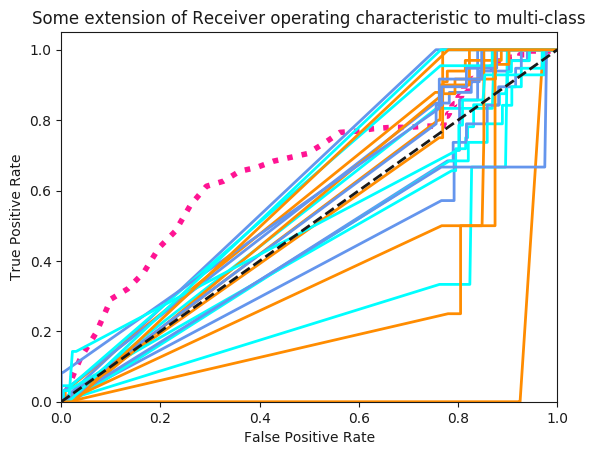

In [312]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_dev_bin[:, i], Y_predict_sparse_prob_dev[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_dev_bin.ravel(), Y_predict_sparse_prob_dev.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# print roc_auc_score(Y_dev_bin, Y_predict_sparse_prob_dev, average='macro')
plot_roc_auc()

### Random Forest Classifier

In [313]:
from sklearn.ensemble import RandomForestClassifier
rand_mod = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, 
                               random_state=None, verbose=0, class_weight="balanced"))

In [314]:
rand_mod.fit(sparse_X_train_xgb, Y_train_bin)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          n_jobs=None)

In [315]:
print rand_mod.score(sparse_X_train_xgb, Y_train_bin)
print rand_mod.score(sparse_X_dev_xgb, Y_dev_bin)

0.15240641711229946
0.0035587188612099642


In [316]:
Y_predict_sparse_prob_train = rand_mod.predict_proba(sparse_X_train_xgb)
Y_predict_sparse_prob_dev = rand_mod.predict_proba(sparse_X_dev_xgb)
Y_predict_sparse_train = rand_mod.predict(sparse_X_train_xgb)
Y_predict_sparse_dev = rand_mod.predict(sparse_X_dev_xgb)

In [317]:
print Y_train_bin.shape
print len(Y_predict_sparse_prob_train)
print roc_auc_score(Y_train_bin, Y_predict_sparse_prob_train, average='micro')
print roc_auc_score(Y_dev_bin, Y_predict_sparse_prob_dev, average='micro')

(1122, 23)
1122
0.7664684824740875
0.5798230657021706


### Voting Based Ensemble Model

Use multiple classifiers to train a Voting based ensemble method

This classifier allows to combine three different classifiers, where the prediction for each data point is determined by the majority of the predictions of the three classifiers. Additionally, the weight paramater allows to assign specific weights to each classifier. Therefore, using these weights, the predicted probability is computed by taking the weighted average of the probabilities. Based on these weighted average probabilities, we can assign class labels. The models are combined in order to reduce the variance, bias and improve the predict power of the model

In [318]:
print type(X_train)

<class 'pandas.core.frame.DataFrame'>


In [319]:
from sklearn.ensemble import VotingClassifier
final_mod = OneVsRestClassifier(VotingClassifier(estimators=[('grad_boos', gbMod5), 
                                         ('ada', model_ad), ('random', rand_mod)], 
                            voting = 'soft',
                            weights = [3.5, 2.7, 1.3]))

In [320]:
final_mod.fit(sparse_X_train_xgb, Y_train_bin)


OneVsRestClassifier(estimator=VotingClassifier(estimators=[('grad_boos', OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=...e))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[3.5, 2.7, 1.3]),
          n_jobs=None)

In [321]:
# final_mod.get_params()

In [322]:
print final_mod.score(sparse_X_train_xgb, Y_train_bin)
print final_mod.score(sparse_X_dev_xgb, Y_dev_bin)
Y_predict_sparse_prob_train = final_mod.predict_proba(sparse_X_train_xgb)
Y_predict_sparse_prob_dev = final_mod.predict_proba(sparse_X_dev_xgb)
Y_predict_sparse_train = final_mod.predict(sparse_X_train_xgb)
Y_predict_sparse_dev = final_mod.predict(sparse_X_dev_xgb)

0.16131907308377896
0.0035587188612099642


In [323]:
print Y_train_bin.shape
print len(Y_predict_sparse_prob_train)
print roc_auc_score(Y_train_bin, Y_predict_sparse_prob_train, average='micro')
print roc_auc_score(Y_dev_bin, Y_predict_sparse_prob_dev, average='micro')

(1122, 23)
1122
0.8396389182800004
0.667982525320325


We see that even though we make use of a pretty powerful technique of ensembling the output of three classifiers, we don't get much boost, in terms of the accuracy, as each of the classifiers themselves do not give high accuracies. But, at the same time, ROC and AUC scores are pretty impressive

In [324]:
### Testing on the test data
Y_predict_sparse_prob_test = final_mod.predict_proba(sparse_X_test_xgb)
Y_predict_sparse_test = final_mod.predict(sparse_X_test_xgb)
print roc_auc_score(Y_test_bin, Y_predict_sparse_prob_test, average='micro')


0.6823269586802351


### Accuracy Vs AUC-ROC
When the data set is highly skewed, AUC-ROC measures are preferred over the plain accuracy measures, as the ROC curve actually looks at the measures of True Positive Rate and False positive rate, in constrast to the accuracy which only looks at the percentage of correctly classified examples. When label classes are highly imbalanced, then the the model tends to learn on the majority class and predicts most of the times for this class. This doesn't give the correct insights into the model's predictive power. Therefore, even though the accuracy measures are low, we rely more on the AUC values to gauge the performance of the model

In [325]:
# feat_encode.classes_

In [326]:
# cw_final_feat = feat_encode.transform(cw_feat)

In [327]:
# print cw_final_feat